# Kennedy and O'Hagan (KOH) Bayesian Model Calibration Example

이 노트북은 Kennedy and O'Hagan (2001)의 Bayesian Model Calibration 프레임워크를 PyMC를 사용하여 구현한 예제입니다. 컴퓨터 시뮬레이션과 실제 관측 데이터를 결합하여 물리적 파라미터를 추정하고, 모델의 불완전성을 고려한 바이어스 텀을 포함합니다.

## Kennedy and O’Hagan (KOH) 의 Bayesian Model Calibration

KOH framework는 실제 측정된 데이터의 값 z를 다음과 같이 모델링합니다.

$$
z = \rho \ \eta(x, t) + \delta(x) + e
$$

* $\eta(x, t)$ 는 컴퓨터 시뮬레이션 코드의 함수이며 $x$는 함수의 인자, $t$는 함수의 파라미터로 해석할 수 있습니다.  
* $\delta(x)$는 컴퓨터 시뮬레이터와 실제 물리 프로세스 사이의 차이를 나타냅니다.
* $e$는 관측 에러로 시뮬레이터 에러와 관측 에러를 모두 포함합니다.

$\eta(x, t)$와 $\delta(x)$는 Gaussian Process의 형태로 가정됩니다.

컴퓨터 시뮬레이션 코드의 데이터는 미리 지정된 $(y_i, x_i, t_i)$로 주어지며 관측된 물리 프로세스의 데이터는 $(z_i, x_i, \theta)$ 로 주어집니다.   
여기서 $y_i$는 시뮬레이션 코드의 아웃풋을 나타내며 관측된 $\theta$는 물리 프로세스에 가장 적합한 모델 파라미터값 입니다.  
$\theta$값은 알 수 없기 때문에 이 역시 MCMC 샘플링의 대상입니다.

2개의 observed data가 설정되며 각각 다음과 같습니다
$$

\begin{align}
y_i &\sim N(f_{c,i}, \sigma_c^2) \\
f_{c,i} &\sim \text{GP for } \eta
\end{align}
$$

$$
\begin{align}
z_i &\sim N(f_{p,i}, \sigma^2) \\
f_{p,i} &\sim \text{GP for } \eta + \text{GP for } \delta
\end{align}
$$

모든 관측 에러는 노말 분포로 가정되었으며 따라서 전체 관측에러인 컴퓨터 에러, 실험 관측에러의 합은 여전히 노말 분포로 표현할 수 있습니다.

## 1. 라이브러리 임포트 및 환경 설정

이 섹션에서는 Bayesian 추론과 Gaussian Process 모델링에 필요한 핵심 라이브러리들을 임포트합니다. 각 라이브러리의 역할과 사용 목적을 명확히 이해하는 것이 중요합니다.

In [1]:
# 이 예제에서 사용되는 주요 라이브러리들입니다:

# 핵심 라이브러리
# - pymc: Bayesian 통계 모델링과 MCMC (Markov Chain Monte Carlo) 추론을 위한 메인 라이브러리
# - numpy: 수치 연산과 다차원 배열 처리

# 데이터 처리 및 분석
# - arviz: Bayesian 분석 결과의 요약 및 시각화
# - pandas: 표 형식 데이터의 입출력 및 분석

# 시각화
# - matplotlib.pyplot: 2D 데이터 시각화

# 저수준 연산 지원
# - pytensor.tensor: 텐서 연산 지원 (PyMC 내부 연산에 사용)

import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt

## 2. 데이터 임포트 및 탐색적 분석

이 섹션에서는 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 로드하고 기본적인 탐색적 분석을 수행합니다. 데이터의 구조와 특성을 이해하는 것이 올바른 모델링의 첫 단계입니다.

In [2]:
# 데이터 파일 로드
# c는 computed (계산된 시뮬레이션 데이터), f는 field (실제 관측된 물리적 프로세스 데이터)를 의미합니다.
df_c = pd.read_csv("../dataset/datacomp_hourly.csv")  # 컴퓨터 시뮬레이션 데이터
df_f = pd.read_csv("../dataset/datafield_hourly.csv")  # 실제 관측 데이터

In [3]:
# 컴퓨터 시뮬레이션 데이터 구조 설명
# - yc: 에너지 사용량 (시뮬레이션 출력값)
# - xc1: 외기온도 (첫 번째 입력 변수)
# - xc2: 상대습도 (두 번째 입력 변수)
# - tc1: 추론하고자 하는 파라미터1 (기기밀도)
# - tc2: 추론하고자 하는 파라미터2 (조명밀도)
# - tc3: 추론하고자 하는 파라미터3 (COP - Coefficient of Performance)

print("컴퓨터 시뮬레이션 데이터 구조:")
df_c

컴퓨터 시뮬레이션 데이터 구조:


,yc,xc1,xc2,tc1,tc2,tc3
0,128.62,25.80,76.83,8.56,5.37,3.10
1,96.13,25.62,77.17,8.56,5.37,3.10
2,85.19,25.32,79.17,8.56,5.37,3.10
3,85.19,25.03,81.17,8.56,5.37,3.10
4,81.71,24.73,83.17,8.56,5.37,3.10
...,...,...,...,...,...,...
235,548.76,27.22,74.58,9.26,7.65,2.89
236,504.63,26.62,75.58,9.26,7.65,2.89
237,439.27,26.32,76.58,9.26,7.65,2.89
238,348.70,26.03,78.75,9.26,7.65,2.89


In [4]:
# 실제 관측 데이터 구조 설명
# - yf: 에너지 사용량 (실제 측정값)
# - xf1: 외기온도 (첫 번째 입력 변수)
# - xf2: 상대습도 (두 번째 입력 변수)
# 주의: 실제 데이터에는 추정하고자 하는 파라미터(tc1, tc2, tc3)가 없습니다.
# 이 파라미터들이 우리가 Bayesian 추론을 통해 찾고자 하는 미지수입니다.

print("실제 관측 데이터 구조:")
df_f

실제 관측 데이터 구조:


,yf,xf1,xf2
0,143.62,25.80,76.83
1,109.34,25.63,77.17
2,95.08,25.33,79.17
3,95.08,25.03,81.17
4,90.93,24.73,83.17
5,97.50,24.43,85.17
6,123.77,24.13,87.17
7,159.02,23.83,89.17
8,134.83,23.99,89.42
9,103.03,24.67,86.67


## 3. 데이터 시각화 및 탐색적 분석

데이터의 공간적 분포와 패턴을 이해하기 위해 시각화를 수행합니다. 이를 통해 데이터의 특성과 잠재적인 관계를 파악할 수 있습니다. 

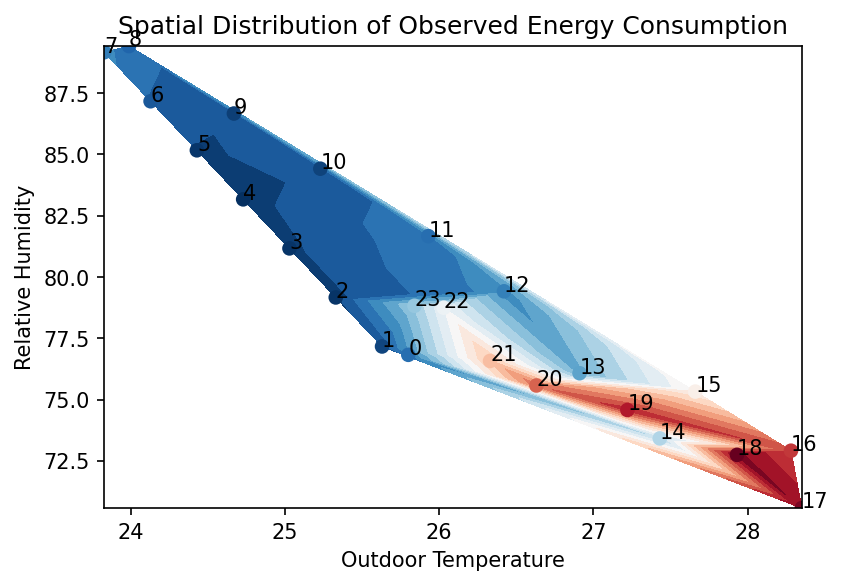

In [5]:
# 실제 물리 프로세스 데이터(df_f)의 2차원 공간 분포를 시각화
# df_f 구조: [zf, xf1, xf2] - 실제 측정값과 2차원 공간 좌표

# 고해상도 플롯 설정 (6x4 인치, 150 DPI)
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# 삼각분할 등고선 플롯 (filled contour)
# df_f.iloc[:, 1]: x1 좌표 (공간의 첫 번째 차원), 건구온도
# df_f.iloc[:, 2]: x2 좌표 (공간의 두 번째 차원), 상대습도  
# df_f.iloc[:, 0]: zf 값 (실제 측정값, 등고선의 높이로 표현)
# levels=20: 20개의 등고선 레벨로 세밀한 분포 표현
# cmap="RdBu_r": 빨강-파랑 색상 맵 (역순, 높은 값이 파란색)
ax.tricontourf(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    df_f.iloc[:, 0],
    levels=20,
    cmap="RdBu_r"
)

# 실제 데이터 포인트들을 산점도로 표시
# 각 점의 색상은 해당 위치의 측정값(zf)에 따라 결정
ax.scatter(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    c=df_f.iloc[:, 0],
    cmap="RdBu_r"
)

# 각 데이터 포인트에 인덱스 번호를 텍스트로 표시
for i in range(df_f.shape[0]):
    ax.text(
        df_f.iloc[i, 1],  # x1 좌표
        df_f.iloc[i, 2],  # x2 좌표
        str(i),           # 포인트 인덱스 번호
        color="black"     # 검은색 텍스트
    )

# 축 레이블과 제목 설정
ax.set_xlabel("Outdoor Temperature")
ax.set_ylabel("Relative Humidity")
ax.set_title("Spatial Distribution of Observed Energy Consumption")

plt.show()

## 4. Bayesian Inference 모델 정의

이 섹션에서는 PyMC를 사용하여 Kennedy and O'Hagan 프레임워크 기반 Bayesian 모델을 정의합니다. 모델은 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 통합하여 물리적 파라미터와 모델 불일치 함수를 함께 추정합니다.

### 4-1. 데이터 탐색 및 통계 요약

모델 정의 전에 데이터의 기본 통계량을 확인하여 데이터의 특성과 분포를 이해합니다.

In [6]:
# 컴퓨터 시뮬레이션 데이터의 기본 통계량 확인
# 데이터의 분포, 범위, 중심 경향 등을 파악하여 적절한 사전 분포 설정에 활용
print("컴퓨터 시뮬레이션 데이터 통계 요약:")
df_c.describe()

컴퓨터 시뮬레이션 데이터 통계 요약:


,yc,xc1,xc2,tc1,tc2,tc3
count,240.000000,240.00000,240.000000,240.000000,240.000000,240.000000
mean,238.212208,25.98625,79.417500,8.001000,6.422000,2.916000
std,153.872389,1.33510,5.316637,0.919768,0.734154,0.337964
min,81.710000,23.82000,70.580000,6.630000,5.370000,2.430000
25%,111.735000,24.95500,75.517500,7.100000,5.720000,2.610000
50%,161.390000,25.88000,78.790000,8.015000,6.360000,2.905000
75%,355.855000,26.98750,83.482500,8.670000,7.170000,3.240000
max,590.090000,28.35000,89.420000,9.340000,7.650000,3.450000


In [7]:
# 실제(측정) 데이터의 기초 통계량을 확인하여 분포와 특성 파악에 활용
print("실제(측정) 데이터 통계 요약:")
df_f.describe()

실제(측정) 데이터 통계 요약:


,yf,xf1,xf2
count,24.000000,24.000000,24.00000
mean,237.079167,25.990000,79.41750
std,154.280131,1.359767,5.41966
min,90.930000,23.830000,70.58000
25%,108.802500,24.955000,75.51750
50%,160.140000,25.885000,78.79000
75%,339.160000,26.987500,83.48250
max,533.400000,28.350000,89.42000


### 4-2. 데이터 정규화 (Data Normalization)

Bayesian 추론과 Gaussian Process 모델링에서 데이터 정규화는 수치적 안정성과 수렴성을 위해 필수적입니다.


In [ ]:
# 데이터 정규화 (Min-Max Scaling)
# 모든 데이터를 [0, 1] 범위로 정규화하여 Gaussian Process 모델링의 수치적 안정성을 확보합니다.

print("=== 컴퓨터 시뮬레이션 데이터 정규화 ===")

# 1. 시뮬레이션 출력값 (y) 정규화
# df_c.iloc[:, 0]: 시뮬레이션 코드의 출력값들
y = df_c.iloc[:, 0].values
y_min = y.min()  # 최솟값 저장 (나중에 역변환용)
y_max = y.max()  # 최댓값 저장 (나중에 역변환용)
y = (y - y_min) / (y_max - y_min)  # Min-Max 정규화: (값 - 최솟값) / (최댓값 - 최솟값)
print(f"y 정규화: 원본 범위 [{y_min:.2f}, {y_max:.2f}] → 정규화 범위 [0, 1]")

# 2. 시뮬레이션 입력 변수 (x_c) 정규화  
# df_c.iloc[:, 1:3]: 공간 좌표 (x1, x2)
x_c = df_c.iloc[:, 1:3].values
x_c_min = x_c.min(axis=0)  # 각 차원별 최솟값
x_c_max = x_c.max(axis=0)  # 각 차원별 최댓값
x_c = (x_c - x_c_min) / (x_c_max - x_c_min)  # 차원별로 Min-Max 정규화
print("x_c 정규화: 각 차원별로 [0, 1] 범위로 변환")

# 3. 시뮬레이션 추가 입력 파라미터, 추정 파라미터 (theta) 정규화
# df_c.iloc[:, 3:]: 모델 추정 파라미터 (theta1, theta2, theta3)
# 주의: 변수명을 t_c에서 theta로 변경 (최신 버전과 일치)
theta = df_c.iloc[:, 3:].values
theta_min = 0  # 하한선을 0으로 고정 (양수 파라미터)
theta_max = theta.max(axis=0)  # 각 파라미터별 최댓값 (정규화에 사용)
theta = (theta - theta_min) / (theta_max - theta_min)  # [0, 최댓값] → [0, 1] 범위로 정규화
print(f"theta 정규화: [0, {theta_max}] → [0, 1] 범위로 변환")

print(f"정규화된 데이터 크기: {y.shape = }, {x_c.shape = }, {theta.shape = }")

# 4. 실제 관측 데이터 정규화
# 위에서 사용된 정규화 파라미터를 실험 데이터 정규화에도 그대로 적용합니다.
# 이를 통해 관측 데이터와 시뮬레이션 데이터가 같은 스케일에서 비교 가능합니다.
z = df_f.iloc[:, 0].values
z = (z - y_min) / (y_max - y_min)  # y의 정규화 파라미터 사용
print(f"z 정규화: y와 동일한 스케일 적용 [{y_min = :.2f}, {y_max = :.2f}] → [0, 1]")

# 5. 실제 관측 좌표 (x_p) 정규화
# 시뮬레이션 좌표와 같은 스케일을 적용
x_p = df_f.iloc[:, 1:3].values
x_p = (x_p - x_c_min) / (x_c_max - x_c_min)  # x_c의 정규화 파라미터 사용
print("x_p 정규화: x_c와 동일한 스케일 적용")

print(f"정규화된 데이터 크기: {z.shape = }, {x_p.shape = }")

=== 컴퓨터 시뮬레이션 데이터 정규화 ===
y 정규화: 원본 범위 [81.71, 590.09] → 정규화 범위 [0, 1]
x_c 정규화: 각 차원별로 [0, 1] 범위로 변환
theta 정규화: [0, [9.34 7.65 3.45]] → [0, 1] 범위로 변환
정규화된 데이터 크기: y.shape = (240,), x_c.shape = (240, 2), theta.shape = (240, 3)
z 정규화: y와 동일한 스케일 적용 [y_min = 81.71, y_max = 590.09] → [0, 1]
x_p 정규화: x_c와 동일한 스케일 적용
정규화된 데이터 크기: z.shape = (24,), x_p.shape = (24, 2)


### 4-3. PyMC 모델 정의 및 구조

이 섹션에서는 Kennedy and O'Hagan 프레임워크에 따라 두 개의 Gaussian Process를 사용하여 모델을 정의합니다:
1. **$\eta$ GP**: 컴퓨터 시뮬레이션 함수 에뮬레이터 (5차원 입력: $x_1, x_2, \theta_1, \theta_2, \theta_3$)
2. **$\delta$ GP**: 모델 불일치 함수 (2차원 입력: $x_1, x_2$)

In [ ]:
# 물리적 파라미터 theta_true의 사전 분포 범위 정의
# 원래 물리적 단위의 최대값([10, 10, 5])을 정규화된 스케일로 변환
# theta_max는 위에서 정규화에 사용된 최댓값
theta_max_prior = np.array([10, 10, 5]) / theta_max
theta_max_prior

array([1.07066381, 1.30718954, 1.44927536])

In [10]:
with pm.Model() as koh_model:
    # ============================================================
    # 1. 컴퓨터 모델 에뮬레이터 GP (eta) 정의
    # ============================================================
    # eta GP는 5차원 입력 공간 (x1, x2, theta1, theta2, theta3)에서 동작
    # 이를 통해 시뮬레이션 함수 eta(x, theta)를 에뮬레이트
    
    # Length-scale 파라미터: 각 입력 차원에서의 함수 변동성 특성을 제어
    # Gamma 분포 사용 이유: 양수만 허용 (분모에 사용되므로 0이면 안됨)
    # shape=5: 5개 입력 차원 (x1, x2, theta1, theta2, theta3) 각각에 대한 독립적인 length-scale
    ls_eta = pm.Gamma("ls_eta", alpha=2, beta=0.5, shape=5)

    # Amplitude 파라미터: GP 함수 값의 전체적인 변동 폭을 결정
    # HalfCauchy 분포 사용 이유: 0을 포함한 양수 허용, heavy-tail로 유연한 사전 분포
    eta_eta = pm.HalfCauchy("eta_eta", beta=1)

    # 커널 함수 정의: Exponential Quadratic (RBF) 커널
    # k(x_i, x_j) = eta^2 * exp(-0.5 * sum((x_i - x_j)^2 / ls^2))
    cov_eta = eta_eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls_eta)
    
    # Latent GP 정의: eta 함수를 직접 모델링
    # Latent GP를 사용하는 이유: 두 개의 GP(eta, delta)를 결합해야 하므로
    gp_eta = pm.gp.Latent(cov_func=cov_eta)

    # ============================================================
    # 2. 모델 불일치 함수 GP (delta) 정의
    # ============================================================
    # delta GP는 2차원 입력 공간 (x1, x2)에서 동작
    # 이를 통해 시뮬레이터와 실제 물리 프로세스 사이의 체계적 차이를 모델링
    
    # Length-scale 파라미터: 공간 변수(x1, x2)에 대한 함수 변동성
    # shape=2: 2개 입력 차원 (x1, x2) 각각에 대한 독립적인 length-scale
    ls_delta = pm.Gamma("ls_delta", alpha=2, beta=0.5, shape=2)
    
    # Amplitude 파라미터: 모델 불일치 함수의 변동 폭
    eta_delta = pm.HalfCauchy("eta_delta", beta=1)
    
    # 커널 함수 정의: Exponential Quadratic (RBF) 커널
    cov_delta = eta_delta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls_delta)
    
    # Latent GP 정의: delta 함수를 직접 모델링
    gp_delta = pm.gp.Latent(cov_func=cov_delta)

    # ============================================================
    # 3. 시뮬레이션 데이터 입력 구성
    # ============================================================
    # 시뮬레이션 데이터의 입력: 공간 좌표(x_c)와 파라미터(theta) 결합
    # theta는 시뮬레이션에 사용된 다양한 파라미터 값들
    X_c = np.hstack([x_c, theta])  # (n_sim, 5) 형태: (x1, x2, theta1, theta2, theta3)

    # ============================================================
    # 4. 물리적 파라미터 추정을 위한 사전 분포 정의
    # ============================================================
    # theta_true: 추정하고자 하는 미지의 물리적 파라미터 (theta1, theta2, theta3)
    # Uniform 분포 사용 이유: 
    #   - 파라미터가 음수가 될 수 없는 물리적 제약
    #   - theta_max_prior까지의 범위에서 균등 분포로 약한 정보 제공
    #   - 변수명을 theta에서 theta_true로 변경하여 시뮬레이션 파라미터(theta)와 구분
    theta_true = pm.Uniform("theta_true", lower=0, upper=theta_max_prior, shape=3)

    # ============================================================
    # 5. 실제 관측 데이터 입력 구성
    # ============================================================
    # 모든 관측치가 동일한 물리 시스템(동일한 theta_true)에서 나왔다고 가정
    # pt.tile을 사용하여 theta_true를 관측치 개수만큼 복제
    X_p = pt.concatenate([x_p, pt.tile(theta_true, (x_p.shape[0], 1))], axis=1)  # (n_obs, 5)

    # ============================================================
    # 6. 전체 입력 데이터 통합
    # ============================================================
    # 시뮬레이션과 실제 관측 데이터를 수직으로 결합하여 하나의 eta GP로 모델링
    # 이를 통해 시뮬레이션 정보가 theta_true 추정에 활용됨
    X_all = pt.concatenate([X_c, X_p], axis=0)  # (n_sim + n_obs, 5)

    # eta GP의 prior 함수값 계산: 모든 입력점(시뮬레이션 + 관측)에서의 함수값
    f_c = gp_eta.prior("f_c", X=X_all)

    # ============================================================
    # 7. 시뮬레이션 관측 모델 정의
    # ============================================================
    # 컴퓨터 시뮬레이션 노이즈 정의
    # sigma_c: 시뮬레이션 과정에서 발생하는 랜덤 노이즈의 표준편차
    # HalfNormal 분포 사용 이유: 양수 제약, 데이터 정규화로 인해 작은 값(0.01) 사용
    sigma_c = pm.HalfNormal("sigma_c", sigma=0.01)

    # 시뮬레이션 관측 데이터 정의
    # f_c[:len(y)]: 시뮬레이션 입력점들에서의 eta 함수값
    y_obs = pm.Normal("y_obs", mu=f_c[:len(y)], sigma=sigma_c, observed=y)

    # ============================================================
    # 8. 실제 관측 모델 정의 (KOH 프레임워크)
    # ============================================================
    # 실제 물리 프로세스는 eta + delta로 모델링됨
    
    # f_p_eta: 실제 관측 입력점들에서의 eta 함수값
    # f_c[len(y):]는 관측 입력점들에서의 eta 함수값을 포함
    f_p_eta = pm.Deterministic("f_p_eta", f_c[len(y):])
    
    # f_p_delta: 모델 불일치 함수값 (2차원 입력 x_p만 사용)
    f_p_delta = gp_delta.prior("f_p_delta", X=x_p)

    # f_p: 실제 물리 프로세스 함수값 = eta + delta
    f_p = pm.Deterministic("f_p", f_p_eta + f_p_delta)

    # 실제 관측 노이즈 정의
    # sigma: 시뮬레이션 노이즈(sigma_c)와 추가 관측 노이즈(sigma_p)의 합
    # 이는 실제 관측 과정에서 발생하는 전체 노이즈를 나타냄
    sigma = pm.Deterministic("sigma", sigma_c + pm.HalfNormal("sigma_p", sigma=0.01))

    # 실제 관측 데이터 정의
    # z_obs: 실제 측정값은 f_p (eta + delta)에 노이즈가 더해진 형태
    z_obs = pm.Normal("z_obs", mu=f_p, sigma=sigma, observed=z)

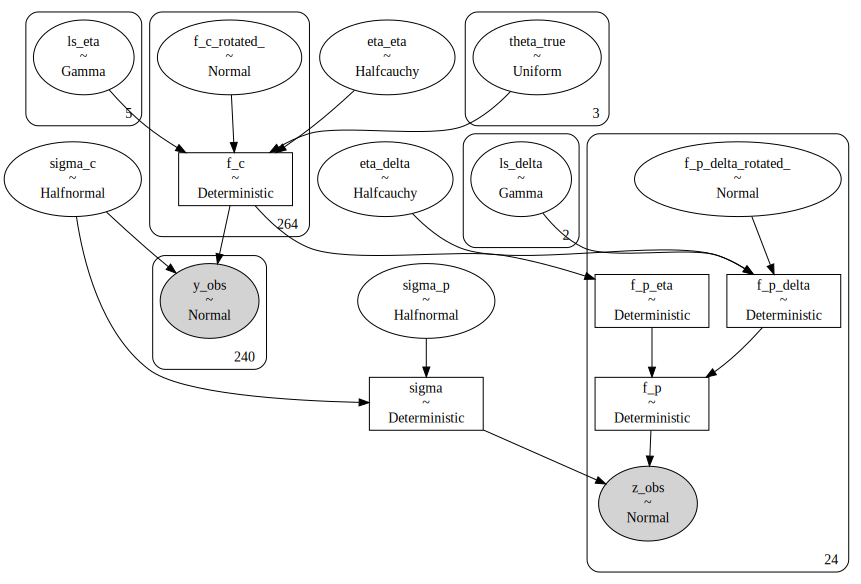

In [11]:
pm.model_to_graphviz(koh_model)

## 5. MCMC 샘플링 수행

이 섹션에서는 NUTS (No-U-Turn Sampler)를 사용하여 사후 분포에서 샘플링을 수행합니다. MCMC를 통해 미지의 파라미터 theta_true, 모델 불일치 함수 delta, 그리고 하이퍼파라미터들의 사후 분포를 근사합니다.

In [12]:
with koh_model:
    # MCMC 샘플링 실행
    # NUTS (No-U-Turn Sampler): Hamiltonian Monte Carlo의 개선된 버전
    trace = pm.sample(
        draws=1000,              # 샘플링할 체인 길이 (실제 샘플 개수)
        tune=1000,               # 워밍업/버닝 단계 길이 (샘플러 파라미터 튜닝)
        chains=1,                # 샘플링할 체인 수 (수렴성 진단을 위해 보통 4개 권장)
        cores=1,                 # 병렬 처리에 사용할 CPU 코어 수
        nuts_sampler="numpyro",  # NumPyro 백엔드 사용 (빠른 성능과 GPU 지원)
        target_accept=0.95,      # 목표 수락률 (높을수록 보수적이고 안정적)
        random_seed=42,
    )

/home/wonjun/Codes/pymc-examples/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
sample: 100%|██████████| 2000/2000 [1:45:24<00:00,  3.16s/it, 1023 steps of size 7.95e-04. acc. prob=0.91]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


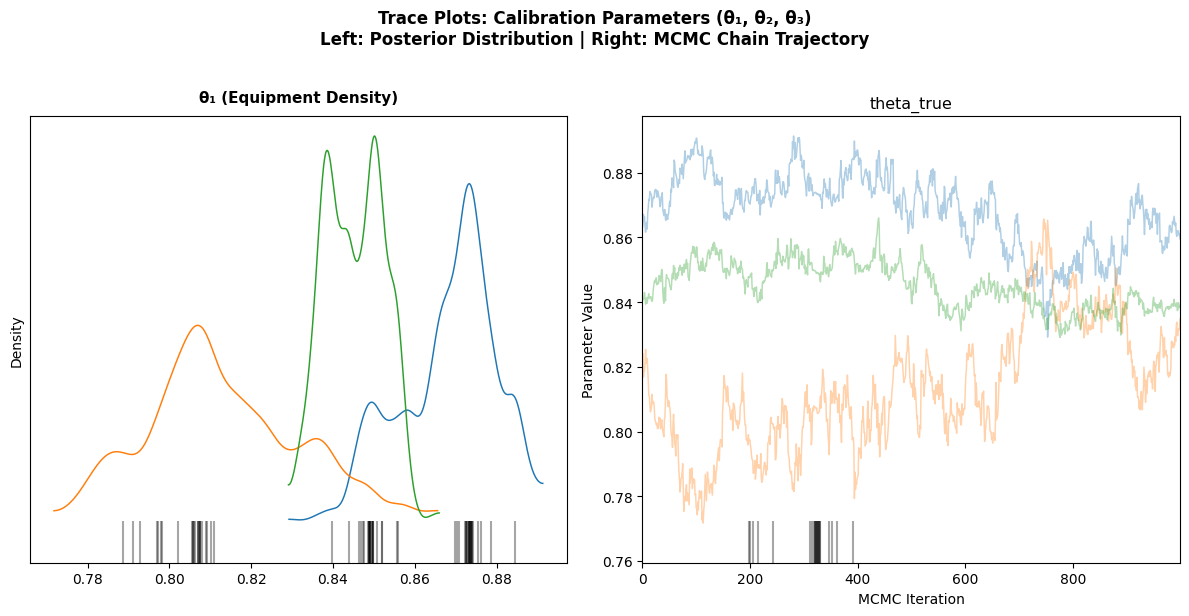

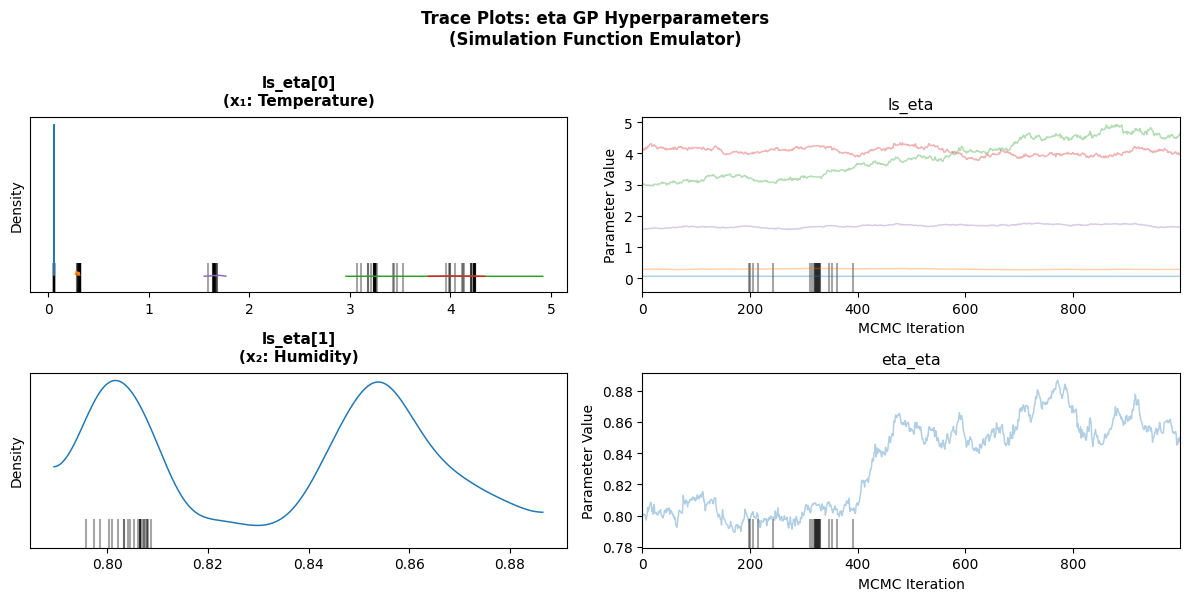

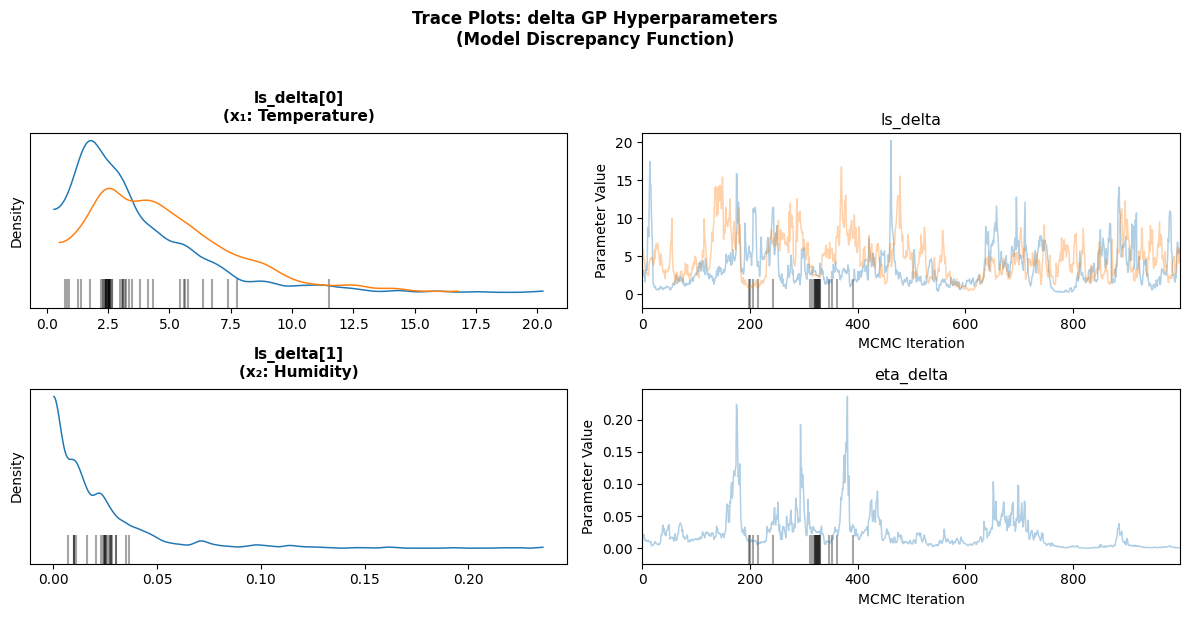

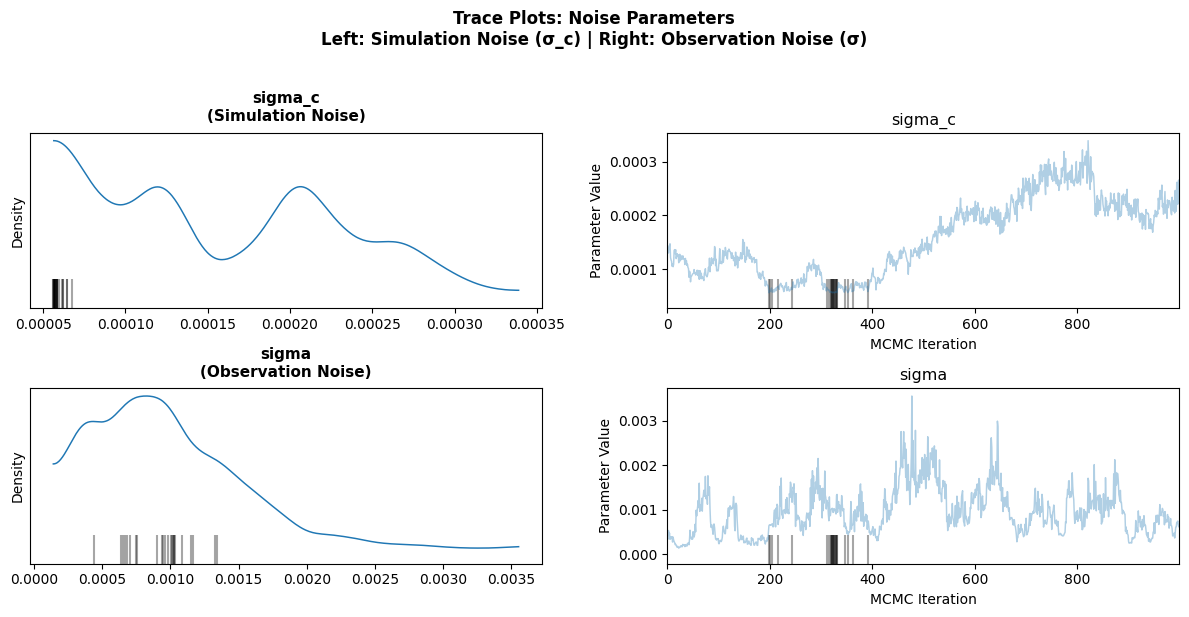

In [59]:
# =============================================================================
# 사후 분포 Trace 플롯 생성 및 시각화
# =============================================================================
# 
# Trace plot은 MCMC 샘플링 결과를 진단하는 핵심 도구입니다.
# - 왼쪽 열: 각 파라미터의 사후 분포 히스토그램 (marginal posterior distribution)
#   → 파라미터의 불확실성과 분포 형태를 확인
# - 오른쪽 열: MCMC 샘플링 과정에서의 파라미터 값 변화 (chain trace)
#   → 수렴성, 자동상관, 시계열 패턴을 확인
#
# 관련 파라미터를 그룹별로 나누어 시각화함으로써 해석의 용이성을 높입니다.
# =============================================================================

# 통일된 플롯 및 폰트 설정
PLOT_FIGSIZE = (12, 6)  # 모든 플롯에 동일한 크기 적용 (너비, 높이)
FONT_SIZE_TITLE = 12     # 전체 플롯 제목 폰트 크기
FONT_SIZE_SUBTITLE = 11  # 개별 파라미터 서브플롯 제목 폰트 크기
FONT_SIZE_AXIS = 10      # 축 레이블 폰트 크기

# 반환값 처리 헬퍼 함수 정의
# az.plot_trace()는 버전/설정에 따라 다양한 형태의 반환값을 가질 수 있어서
# 안전하게 처리하기 위한 함수를 정의합니다.
def process_trace_result(trace_result):
    """
    az.plot_trace()의 반환값을 처리하여 figure와 axes를 추출합니다.
    
    Args:
        trace_result: az.plot_trace()의 반환값 (tuple, figure, 또는 axes 배열)
    
    Returns:
        fig: matplotlib Figure 객체
        axes: numpy array 형태의 axes 배열 (1D로 flatten)
    """
    if isinstance(trace_result, tuple) and len(trace_result) == 2:
        # (figure, axes) 튜플로 반환된 경우
        fig, axes = trace_result
    elif hasattr(trace_result, 'suptitle'):
        # Figure 객체로 반환된 경우
        fig = trace_result
        axes = np.array(fig.get_axes())
    else:
        # axes 배열만 반환된 경우
        if isinstance(trace_result, (list, np.ndarray)):
            axes = np.array(trace_result)
        else:
            axes = np.array([trace_result])
        # 첫 번째 axes에서 figure 추출 (없으면 현재 figure 사용)
        fig = axes[0].figure if hasattr(axes[0], 'figure') and axes[0].figure is not None else plt.gcf()
    
    # axes를 1D 배열로 flatten
    axes = np.array(axes).flatten()
    return fig, axes

# =============================================================================
# 1. 칼리브레이션 파라미터 Trace Plot
# =============================================================================
# theta_true는 모델 칼리브레이션의 핵심으로, 실제 물리 프로세스의 파라미터입니다.
# 3개 파라미터 (θ₁: Equipment Density, θ₂: Lighting Density, θ₃: COP)를 포함합니다.

trace_result = az.plot_trace(
    trace, 
    var_names=["theta_true"],
    compact=True,           # 서브플롯을 간결하게 배치
    divergences="bottom",   # divergence 샘플을 하단에 표시
    figsize=PLOT_FIGSIZE    # 통일된 플롯 크기 사용
)

fig1, axes1 = process_trace_result(trace_result)

# 전체 플롯 제목 설정
fig1.suptitle("Trace Plots: Calibration Parameters (θ₁, θ₂, θ₃)\n" +
              "Left: Posterior Distribution | Right: MCMC Chain Trajectory", 
              fontsize=FONT_SIZE_TITLE, y=1.02, fontweight="bold")

# 각 파라미터에 대한 레이블 정의
# theta_true는 3차원 벡터로, 각 차원별로 의미가 다릅니다.
param_labels = [
    "θ₁ (Equipment Density)",    # 기기밀도
    "θ₂ (Lighting Density)",     # 조명밀도
    "θ₃ (COP)"                   # Coefficient of Performance
]

# trace plot 구조: 각 파라미터당 2개 서브플롯 (0번: 분포 히스토그램, 1번: 체인 trace)
n_params = min(len(param_labels), len(axes1) // 2)
for i in range(n_params):
    # 분포 히스토그램 플롯 (왼쪽 열)
    if i*2 < len(axes1):
        axes1[i*2].set_ylabel("Density", fontsize=FONT_SIZE_AXIS)
        axes1[i*2].set_title(param_labels[i], fontsize=FONT_SIZE_SUBTITLE, 
                            fontweight="bold", pad=10)
    
    # 체인 trace 플롯 (오른쪽 열)
    if i*2 + 1 < len(axes1):
        axes1[i*2 + 1].set_ylabel("Parameter Value", fontsize=FONT_SIZE_AXIS)
        axes1[i*2 + 1].set_xlabel("MCMC Iteration", fontsize=FONT_SIZE_AXIS)

plt.tight_layout()
plt.show()

# =============================================================================
# 2. eta GP 하이퍼파라미터 Trace Plot
# =============================================================================
# eta GP는 시뮬레이션 함수를 에뮬레이트하는 Gaussian Process입니다.
# 5차원 length-scale (x₁, x₂, θ₁, θ₂, θ₃)과 1개의 amplitude 파라미터를 가집니다.

trace_result = az.plot_trace(
    trace,
    var_names=["ls_eta", "eta_eta"],
    compact=True,
    divergences="bottom",
    figsize=PLOT_FIGSIZE
)

fig2, axes2 = process_trace_result(trace_result)

fig2.suptitle("Trace Plots: eta GP Hyperparameters\n" +
              "(Simulation Function Emulator)", 
              fontsize=FONT_SIZE_TITLE, y=0.995, fontweight="bold")

# 각 하이퍼파라미터에 대한 설명이 포함된 레이블
# ls_eta[0-4]: 각 입력 차원에 대한 length-scale
# eta_eta: 전체 함수의 amplitude (변동 폭)
ls_labels = [
    "ls_eta[0]\n(x₁: Temperature)",    # 외기온도 차원의 length-scale
    "ls_eta[1]\n(x₂: Humidity)",       # 상대습도 차원의 length-scale
    "ls_eta[2]\n(θ₁: Equipment)",      # 기기밀도 차원의 length-scale
    "ls_eta[3]\n(θ₂: Lighting)",       # 조명밀도 차원의 length-scale
    "ls_eta[4]\n(θ₃: COP)",            # COP 차원의 length-scale
    "eta_eta\n(Amplitude)"             # GP 함수의 전체 변동 폭
]

axes2 = np.array(axes2).flatten()
n_params = min(len(ls_labels), len(axes2) // 2)
for i in range(n_params):
    if i*2 < len(axes2):
        axes2[i*2].set_ylabel("Density", fontsize=FONT_SIZE_AXIS)
        axes2[i*2].set_title(ls_labels[i], fontsize=FONT_SIZE_SUBTITLE, 
                            fontweight="bold", pad=10)
    if i*2 + 1 < len(axes2):
        axes2[i*2 + 1].set_ylabel("Parameter Value", fontsize=FONT_SIZE_AXIS)
        axes2[i*2 + 1].set_xlabel("MCMC Iteration", fontsize=FONT_SIZE_AXIS)

plt.tight_layout()
plt.show()

# =============================================================================
# 3. delta GP 하이퍼파라미터 Trace Plot
# =============================================================================
# delta GP는 모델 불일치 함수를 나타내는 Gaussian Process입니다.
# KOH 프레임워크의 핵심으로, 시뮬레이터와 실제 물리 프로세스 사이의 체계적 차이를 모델링합니다.
# 2차원 length-scale (x₁, x₂)과 1개의 amplitude 파라미터를 가집니다.

trace_result = az.plot_trace(
    trace,
    var_names=["ls_delta", "eta_delta"],
    compact=True,
    divergences="bottom",
    figsize=PLOT_FIGSIZE
)

fig3, axes3 = process_trace_result(trace_result)

fig3.suptitle("Trace Plots: delta GP Hyperparameters\n" +
              "(Model Discrepancy Function)", 
              fontsize=FONT_SIZE_TITLE, y=1.02, fontweight="bold")

# 모델 불일치 함수의 하이퍼파라미터 레이블
# delta GP는 입력 공간(x₁, x₂)에만 의존하므로 2차원 length-scale만 필요
delta_labels = [
    "ls_delta[0]\n(x₁: Temperature)",  # 외기온도 차원의 length-scale
    "ls_delta[1]\n(x₂: Humidity)",     # 상대습도 차원의 length-scale
    "eta_delta\n(Amplitude)"           # 모델 불일치 함수의 변동 폭
]

axes3 = np.array(axes3).flatten()
n_params = min(len(delta_labels), len(axes3) // 2)
for i in range(n_params):
    if i*2 < len(axes3):
        axes3[i*2].set_ylabel("Density", fontsize=FONT_SIZE_AXIS)
        axes3[i*2].set_title(delta_labels[i], fontsize=FONT_SIZE_SUBTITLE, 
                            fontweight="bold", pad=10)
    if i*2 + 1 < len(axes3):
        axes3[i*2 + 1].set_ylabel("Parameter Value", fontsize=FONT_SIZE_AXIS)
        axes3[i*2 + 1].set_xlabel("MCMC Iteration", fontsize=FONT_SIZE_AXIS)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. 노이즈 파라미터 Trace Plot
# =============================================================================
# 노이즈 파라미터는 관측 과정에서 발생하는 불확실성을 나타냅니다.
# sigma_c: 시뮬레이션 데이터의 노이즈 (에뮬레이터 오차)
# sigma: 실제 관측 데이터의 노이즈 (시뮬레이션 노이즈 + 추가 관측 오차)

trace_result = az.plot_trace(
    trace,
    var_names=["sigma_c", "sigma"],
    compact=True,
    divergences="bottom",
    figsize=PLOT_FIGSIZE
)

fig4, axes4 = process_trace_result(trace_result)

fig4.suptitle("Trace Plots: Noise Parameters\n" +
              "Left: Simulation Noise (σ_c) | Right: Observation Noise (σ)", 
              fontsize=FONT_SIZE_TITLE, y=1.02, fontweight="bold")

# 노이즈 파라미터 레이블
noise_labels = [
    "sigma_c\n(Simulation Noise)",      # 시뮬레이션 노이즈 (에뮬레이터 오차)
    "sigma\n(Observation Noise)"        # 관측 노이즈 (전체 측정 오차)
]

axes4 = np.array(axes4).flatten()
n_params = min(len(noise_labels), len(axes4) // 2)
for i in range(n_params):
    if i*2 < len(axes4):
        axes4[i*2].set_ylabel("Density", fontsize=FONT_SIZE_AXIS)
        axes4[i*2].set_title(noise_labels[i], fontsize=FONT_SIZE_SUBTITLE, 
                            fontweight="bold", pad=10)
    if i*2 + 1 < len(axes4):
        axes4[i*2 + 1].set_ylabel("Parameter Value", fontsize=FONT_SIZE_AXIS)
        axes4[i*2 + 1].set_xlabel("MCMC Iteration", fontsize=FONT_SIZE_AXIS)

plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'axes'

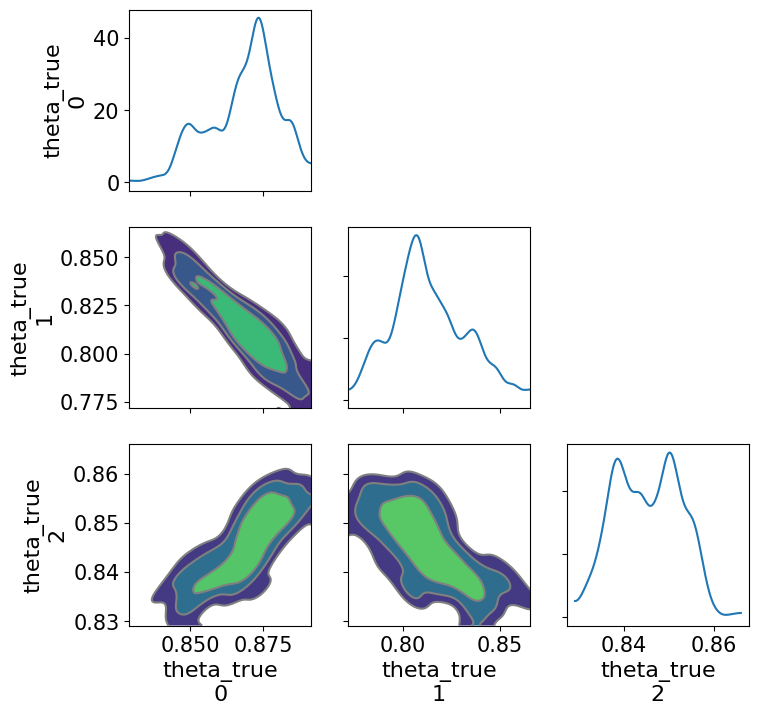

In [62]:
# theta_true 파라미터 간의 상관관계 시각화
# 대각선: 각 파라미터의 주변 분포 (marginal distribution)
# 비대각선: 파라미터 쌍 간의 결합 분포 (joint distribution)
# 이를 통해 파라미터 간의 상관성과 불확실성 구조 파악
# 주의: 변수명을 theta에서 theta_true로 변경
# theta_true 파라미터 페어플롯: 상관관계/결합분포/주변분포 시각화
# 각 파라미터의 실제 의미를 레이블로 표시 (예: 기기밀도, 조명밀도, COP 등)
theta_labels = [
    "기기밀도\n(Device Power Density)",
    "조명밀도\n(Lighting Power Density)",
    "COP\n(Coefficient of Performance)"
]

# 한글 폰트 사용 등 그래프 스타일 조정(필요시)
# plt.rc('font', family='NanumGothic')  # 주석 해제시 한글폰트 적용

pair_fig = az.plot_pair(
    trace,
    var_names=["theta_true"],
    kind='kde',
    marginals=True,
    gridsize=100,
    figsize=(8, 8),
    textsize=15
)

# 축 레이블 실제 해석 가능한 이름으로 바꾸기
# get_axes()나 reshape로 꼬일 바에 직접 축 리스트로 접근한다
axes = pair_fig.axes  # pair_fig.axes 는 리스트 (길이 6) (matplotlib >=3.4), 또는 arviz 내부 구현에 따라 다를 수 있음

# 3x3 격자에 맞게 axes 정렬 (matplotlib, arviz가 subplot 순서를 row-major로 생성하므로)
if len(axes) == 9:
    axes = np.array(axes).reshape((3, 3))
else:
    # 만약 9개가 아니라면 오류방지를 위해 2차원 배열로 만들기
    axes = np.array(axes).reshape(-1, -1)

for i in range(3):
    axes[2, i].set_xlabel(theta_labels[i], fontsize=14, fontweight='bold', labelpad=8)
    axes[i, 0].set_ylabel(theta_labels[i], fontsize=14, fontweight='bold', labelpad=8)
    # 서브타이틀 (대각선 플롯 위에) 추가
    axes[i, i].set_title(theta_labels[i], fontsize=13, fontweight='bold', pad=12)

pair_fig.suptitle(
    "Trace Pair Plot: θₜᵣᵤₑ Parameter Correlations\n"
    "(Device Density, Lighting Density, COP)", 
    fontsize=16, y=1.07, fontweight="bold"
)

plt.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

## 원래 차원으로 복원하여 함수 파라미터 시각화

### 역변환의 필요성

MCMC 샘플링을 통해 얻은 `theta_true` 파라미터들은 **정규화된 [0, 1] 범위**에 있습니다. 하지만 실제 물리적 해석과 비교를 위해서는 **원래의 물리적 단위**로 복원해야 합니다.

### 역변환 과정

#### **1. 정규화 파라미터 복원**
```python
trace_ = trace.copy()
trace_.posterior.theta_true.values *= theta_max[None, None, :]
```

**수학적 표현**:
$$\theta_{true,\text{original}} = \theta_{true,\text{normalized}} \times \theta_{\text{max}}$$

여기서:
- $\theta_{true,\text{normalized}}$: MCMC로 샘플링된 정규화된 파라미터 [0, 1]
- $\theta_{\text{max}}$: 정규화 시 사용된 최댓값 벡터
- $\theta_{true,\text{original}}$: 원래 물리적 단위의 파라미터

#### **2. 차원 구조 설명**
```python
theta_max[None, None, :]
```

이 표현의 차원 구조:
- `theta_max`: (3,) - 3개 파라미터의 최댓값
- `[None, None, :]`: (1, 1, 3) - 브로드캐스팅을 위한 차원 확장
- `trace.posterior.theta_true`: (1, 1000, 3) - (chain, draw, parameter)
- 결과: (1, 1000, 3) - 모든 샘플에 대해 역변환 적용


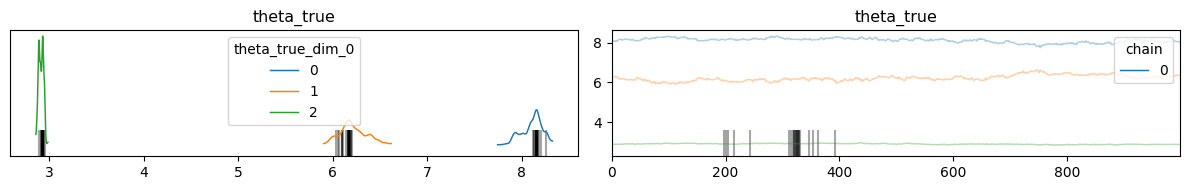

In [21]:

# theta_true 파라미터를 원래 물리적 단위로 역변환
# 정규화된 [0, 1] 범위에서 원래 파라미터 범위로 복원
trace_ = trace.copy()
# theta_max는 위에서 정규화 시 사용된 최댓값
trace_.posterior.theta_true.values *= theta_max[None, None, :]  # 브로드캐스팅으로 모든 샘플에 적용

# 역변환된 theta_true 값들의 사후 분포 시각화
# 이제 물리적 단위로 해석 가능 (기기밀도, 조명밀도, COP)
az.plot_trace(trace_, legend=True, var_names=["theta_true"])
plt.tight_layout()
plt.show()

In [22]:
with koh_model:
    samples = pm.sample_posterior_predictive(
        trace,
        var_names=["y_obs", "z_obs"],
    )

Sampling: [y_obs, z_obs]


Output()

In [23]:
samples.posterior_predictive.y_obs.mean(axis=(0, 1))

<xarray.DataArray 'y_obs' (y_obs_dim_0: 240)> Size: 2kB
array([ 9.23122400e-02,  2.83103008e-02,  6.90219824e-03,  6.81963413e-03,
       -2.27791454e-05,  1.00260393e-02,  5.97428993e-02,  1.31964355e-01,
        8.73354400e-02,  2.54848338e-02,  2.27111184e-02,  7.90807655e-02,
        1.18615854e-01,  1.79056366e-01,  2.77048160e-01,  4.34888290e-01,
        7.02660702e-01,  8.03739887e-01,  8.26085687e-01,  7.45513465e-01,
        6.59859567e-01,  5.42878238e-01,  3.90414642e-01,  2.52317805e-01,
        9.82262163e-02,  2.86874181e-02,  7.54043574e-03,  7.61133321e-03,
        5.07119290e-04,  1.13096619e-02,  5.91362067e-02,  1.26249721e-01,
        8.27419314e-02,  2.38529772e-02,  2.18736162e-02,  9.16072918e-02,
        1.44049999e-01,  2.18782062e-01,  3.36423529e-01,  5.23514531e-01,
        8.37062284e-01,  9.35235814e-01,  9.47393840e-01,  8.35884557e-01,
        7.19093947e-01,  5.81212412e-01,  4.14403257e-01,  2.67984795e-01,
        1.11341622e-01,  5.26024550e-02,  2.77196929e-02,  2.77022504e-02,
        1.90975486e-02,  3.35138087e-02,  8.17447680e-02,  1.41048516e-01,
        9.55642623e-02,  3.88486693e-02,  4.60612439e-02,  1.09354136e-01,
        1.40298920e-01,  1.97319399e-01,  2.90861805e-01,  4.25918309e-01,
        6.78780889e-01,  7.72131243e-01,  7.91829376e-01,  7.12915688e-01,
        6.29746289e-01,  5.21630122e-01,  3.79367655e-01,  2.54688172e-01,
        1.12424468e-01,  4.86127740e-02,  2.22516577e-02,  2.22716894e-02,
        1.45067388e-02,  2.63275567e-02,  7.90738034e-02,  1.53128889e-01,
...
        8.51244507e-01,  9.52787630e-01,  9.67759597e-01,  8.60336659e-01,
        7.48277574e-01,  6.15189000e-01,  4.48739893e-01,  3.05407130e-01,
        1.37999051e-01,  6.12610147e-02,  2.81363140e-02,  2.80995986e-02,
        2.01797684e-02,  3.21552601e-02,  8.77022047e-02,  1.67070898e-01,
        1.16778127e-01,  4.79466721e-02,  6.15150675e-02,  1.40851864e-01,
        1.79179312e-01,  2.48194269e-01,  3.60156065e-01,  5.40533148e-01,
        8.53981824e-01,  9.71792529e-01,  9.96917876e-01,  9.00990778e-01,
        7.99245787e-01,  6.62430900e-01,  4.84415558e-01,  3.23996365e-01,
        1.08362954e-01,  4.87630491e-02,  2.45552308e-02,  2.45607843e-02,
        1.63345098e-02,  2.98139909e-02,  7.87505153e-02,  1.41325737e-01,
        9.56468217e-02,  3.74164251e-02,  4.24707313e-02,  1.03831357e-01,
        1.34704809e-01,  1.90847548e-01,  2.83062610e-01,  4.19098486e-01,
        6.70051545e-01,  7.65628401e-01,  7.87156607e-01,  7.11607279e-01,
        6.31594141e-01,  5.23991821e-01,  3.80975048e-01,  2.54366809e-01,
        1.78494460e-01,  1.04464636e-01,  5.87174476e-02,  5.77723548e-02,
        4.79823557e-02,  6.35612124e-02,  1.24289003e-01,  2.04855010e-01,
        1.48780962e-01,  7.95354052e-02,  1.26395323e-01,  1.84776193e-01,
        2.12420858e-01,  2.74822555e-01,  3.79295683e-01,  5.38827617e-01,
        8.39443200e-01,  9.66518092e-01,  9.99993105e-01,  9.18688775e-01,
        8.31890655e-01,  7.03314927e-01,  5.25173367e-01,  3.64449419e-01])
Coordinates:
  * y_obs_dim_0  (y_obs_dim_0) int64 2kB 0 1 2 3 4 5 ... 234 235 236 237 238 239

In [24]:
y

array([9.22734962e-02, 2.83646092e-02, 6.84527322e-03, 6.84527322e-03,
       0.00000000e+00, 1.00712066e-02, 5.96994374e-02, 1.32007553e-01,
       8.73559149e-02, 2.54730713e-02, 2.27585664e-02, 7.90550376e-02,
       1.18592392e-01, 1.79058972e-01, 2.77076203e-01, 4.34910893e-01,
       7.02663362e-01, 8.03768834e-01, 8.26094654e-01, 7.45564342e-01,
       6.59860734e-01, 5.42861639e-01, 3.90416617e-01, 2.52389945e-01,
       9.83319564e-02, 2.86006531e-02, 7.57307526e-03, 7.57307526e-03,
       5.11428459e-04, 1.12907667e-02, 5.91683386e-02, 1.26263818e-01,
       8.27137181e-02, 2.38601046e-02, 2.18930721e-02, 9.15850348e-02,
       1.44026122e-01, 2.18734018e-01, 3.36421574e-01, 5.23506039e-01,
       8.37090365e-01, 9.35245289e-01, 9.47401550e-01, 8.35910146e-01,
       7.19107754e-01, 5.81238444e-01, 4.14414414e-01, 2.67949172e-01,
       1.11314371e-01, 5.25591093e-02, 2.77154884e-02, 2.77154884e-02,
       1.91392266e-02, 3.34788937e-02, 8.17498721e-02, 1.41036233e-01,
      

In [25]:
samples.posterior_predictive.z_obs.mean(axis=(0, 1))

<xarray.DataArray 'z_obs' (z_obs_dim_0: 24)> Size: 192B
array([0.12177411, 0.05478652, 0.02616295, 0.02621313, 0.01815626,
       0.03076595, 0.08283882, 0.15201904, 0.10421685, 0.04214542,
       0.05080339, 0.1211855 , 0.15616729, 0.21917099, 0.3216885 ,
       0.47988723, 0.76172685, 0.86630027, 0.88871325, 0.80124337,
       0.70837161, 0.58654587, 0.42762863, 0.28561033])
Coordinates:
  * z_obs_dim_0  (z_obs_dim_0) int64 192B 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23

## 6. 베이지안 추론 및 모델 칼리브레이션 결과 분석

이 섹션에서는 MCMC 샘플링 결과를 바탕으로 종합적인 베이지안 추론 및 모델 칼리브레이션 분석을 수행합니다. 수렴성 진단, 사후 분포 분석, 모델 검증, 그리고 칼리브레이션 결과 해석을 포함합니다.


### 6-1. 수렴성 진단 (Convergence Diagnostics)

MCMC 샘플링의 수렴성은 신뢰할 수 있는 베이지안 추론의 전제조건입니다. 여러 진단 도구를 사용하여 샘플러가 목표 분포에서 충분히 잘 샘플링하고 있는지 확인합니다.


In [26]:
# 수렴성 진단 요약 통계
# R-hat: 체인 간 수렴성을 측정 (1.0에 가까울수록 좋음, 일반적으로 < 1.01이 좋음)
# ESS (Effective Sample Size): 독립적인 샘플 수, 클수록 좋음
# 
# 주의: 현재 단일 체인 사용 중이므로 R-hat는 계산되지 않음
# ESS는 계산되지만 단일 체인의 한계로 해석에 주의 필요

summary = az.summary(trace, var_names=["theta_true", "ls_eta", "ls_delta", "eta_eta", "eta_delta", "sigma_c", "sigma"])
print("=== 수렴성 진단 및 사후 분포 요약 통계 ===")
print(summary)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


=== 수렴성 진단 및 사후 분포 요약 통계 ===
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_true[0]  0.868  0.012   0.845    0.886      0.009    0.002       2.0   
theta_true[1]  0.813  0.019   0.781    0.850      0.014    0.003       2.0   
theta_true[2]  0.845  0.007   0.834    0.858      0.006    0.001       2.0   
ls_eta[0]      0.059  0.000   0.059    0.060      0.000    0.000       9.0   
ls_eta[1]      0.290  0.011   0.272    0.308      0.008    0.002       2.0   
ls_eta[2]      3.839  0.604   2.959    4.723      0.561    0.086       1.0   
ls_eta[3]      4.066  0.118   3.873    4.285      0.062    0.010       4.0   
ls_eta[4]      1.673  0.048   1.585    1.752      0.035    0.006       2.0   
ls_delta[0]    3.525  2.646   0.276    8.404      0.390    0.213      33.0   
ls_delta[1]    4.759  2.827   0.501    9.647      0.508    0.307      29.0   
eta_eta        0.834  0.028   0.793    0.876      0.026    0.002       2.0   
eta_delta      0.023  0.027   0.000

#### Rank Plots

Rank plot은 각 파라미터의 샘플이 균등하게 분포되어 있는지 확인합니다. 이상적인 경우 각 rank bin에 비슷한 수의 샘플이 있어야 합니다.


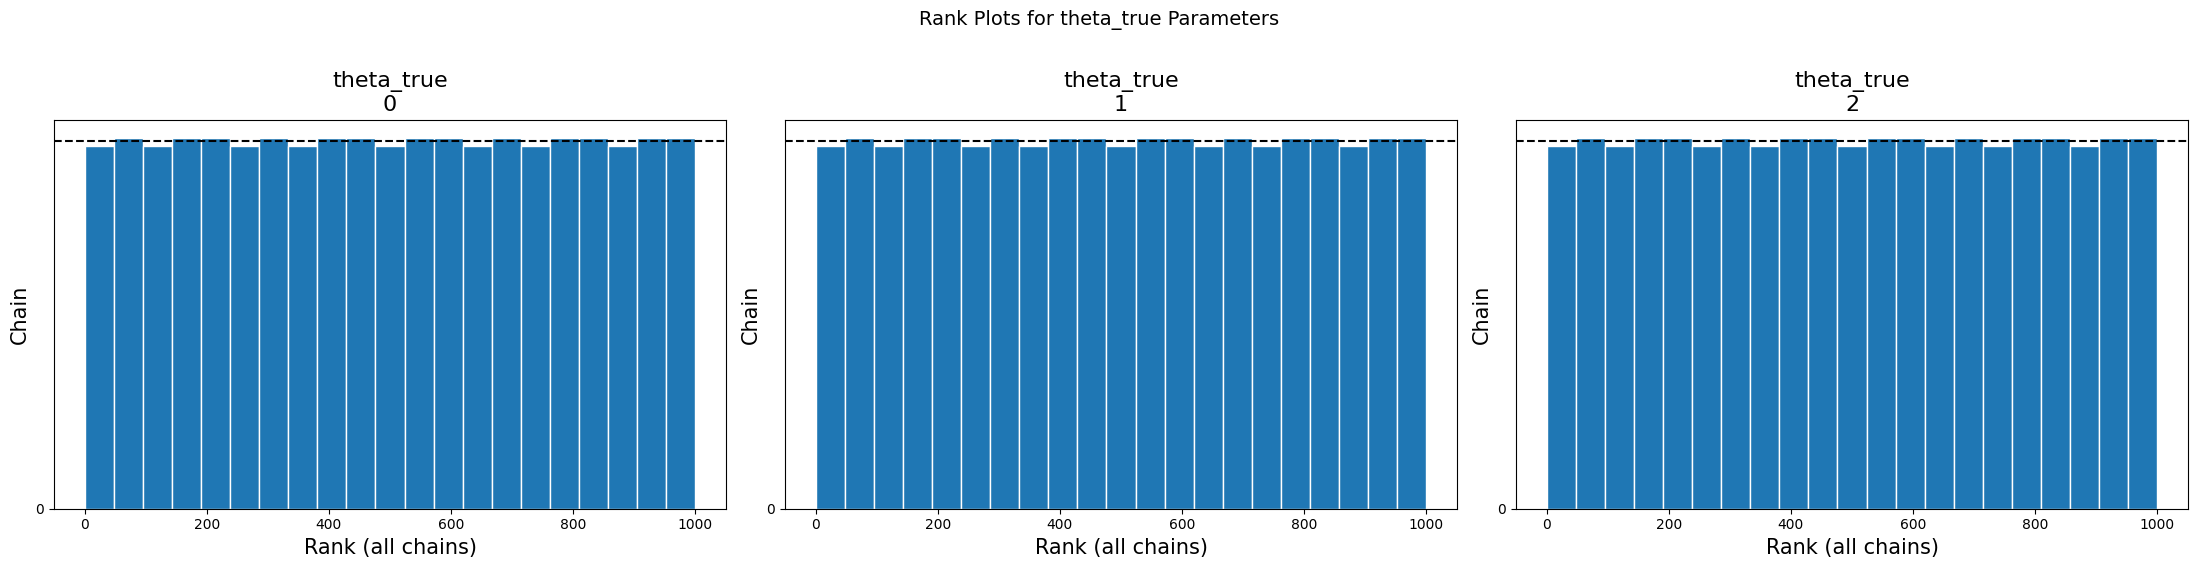

In [27]:
# Rank plot: 파라미터 샘플의 rank 분포를 시각화
# 각 파라미터에 대해 rank가 균등하게 분포되어 있으면 수렴성이 좋다고 판단
# theta_true 파라미터에 대한 rank plot
az.plot_rank(trace, var_names=["theta_true"], ref_line=True)
plt.suptitle("Rank Plots for theta_true Parameters", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


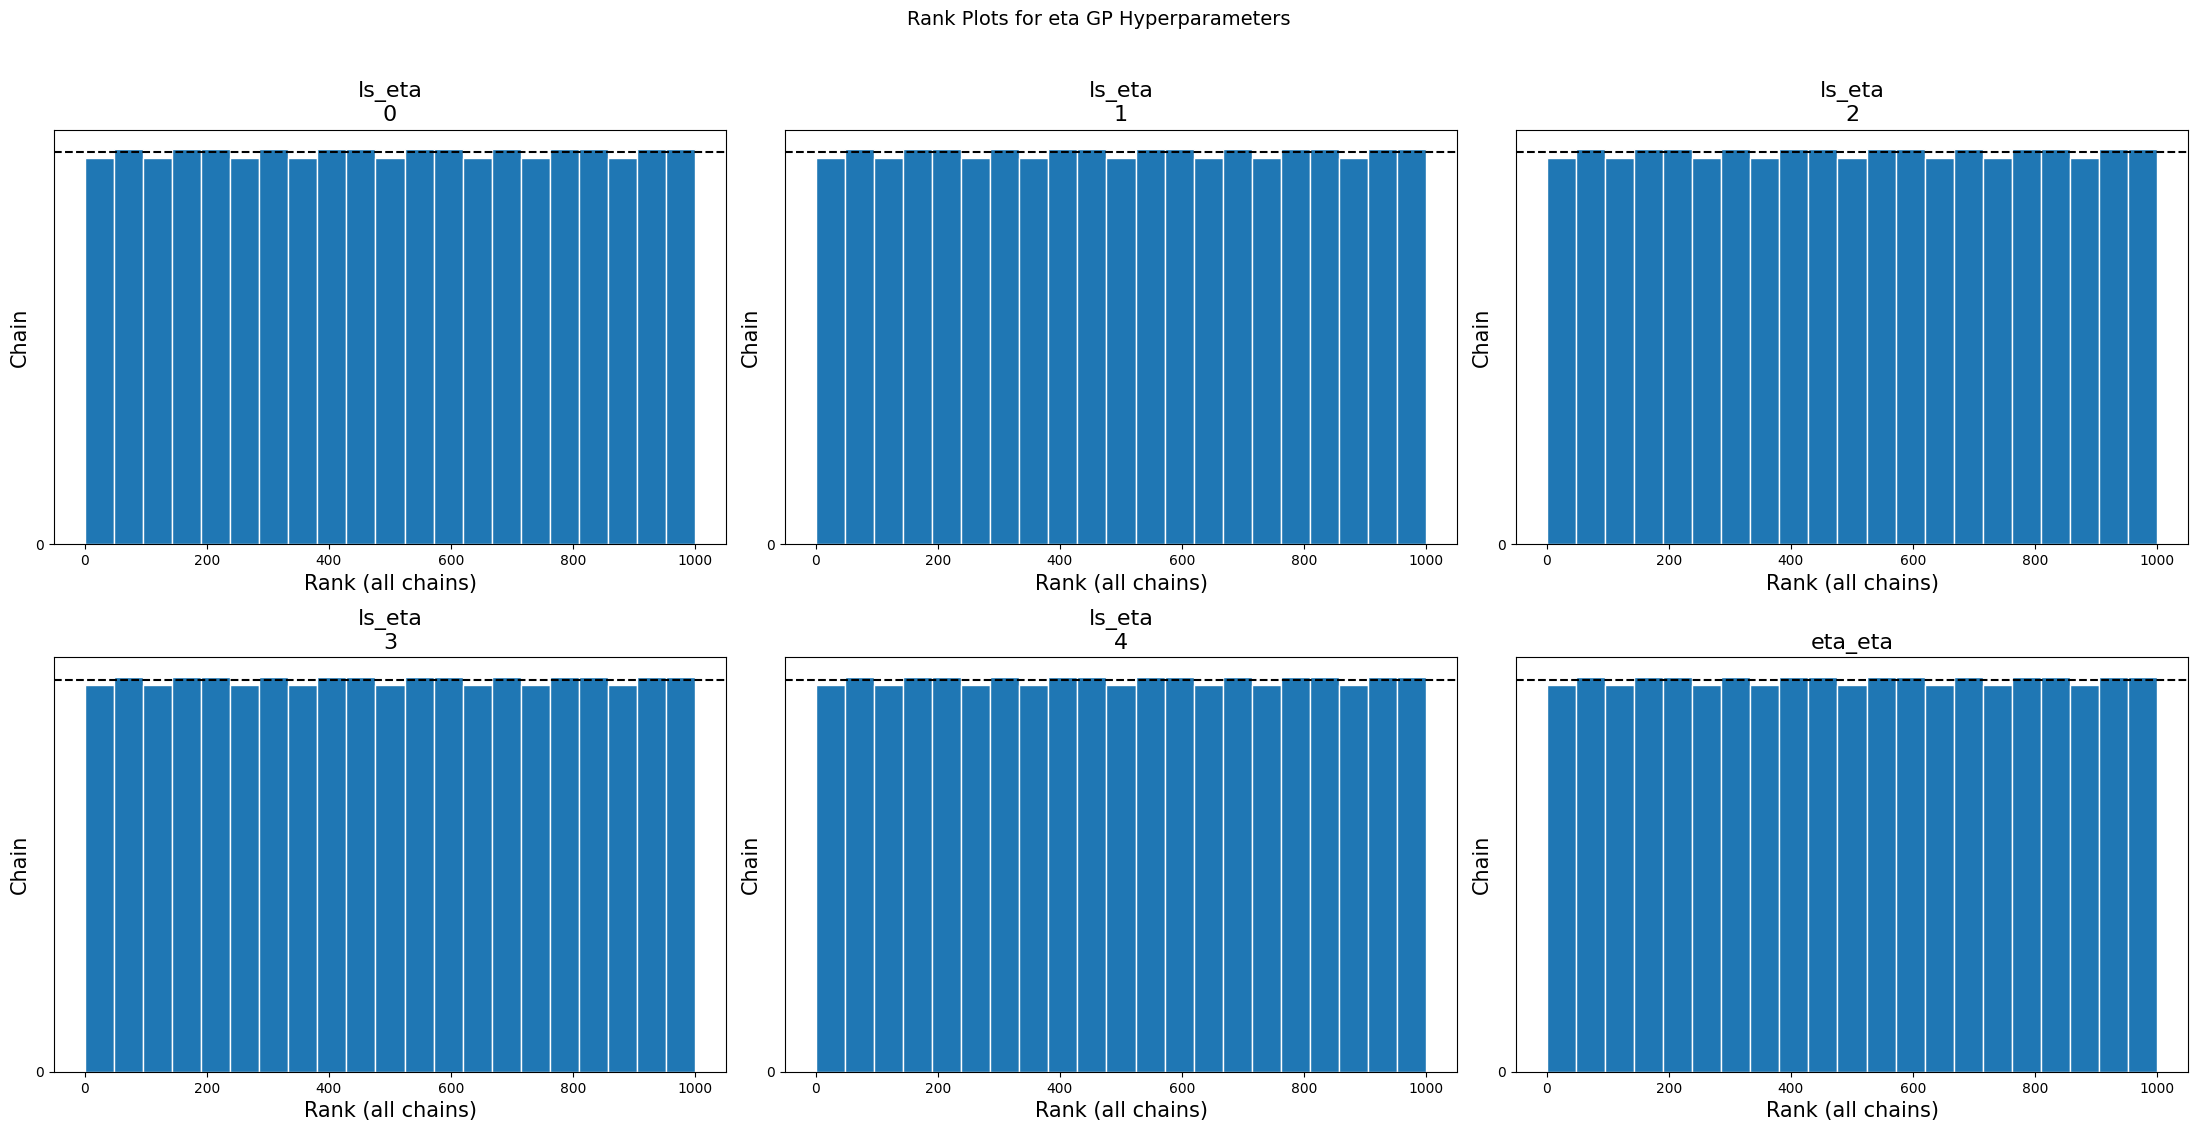

In [28]:
# GP 하이퍼파라미터들에 대한 rank plot
# eta GP의 length-scale과 amplitude 파라미터
az.plot_rank(trace, var_names=["ls_eta", "eta_eta"], ref_line=True)
plt.suptitle("Rank Plots for eta GP Hyperparameters", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


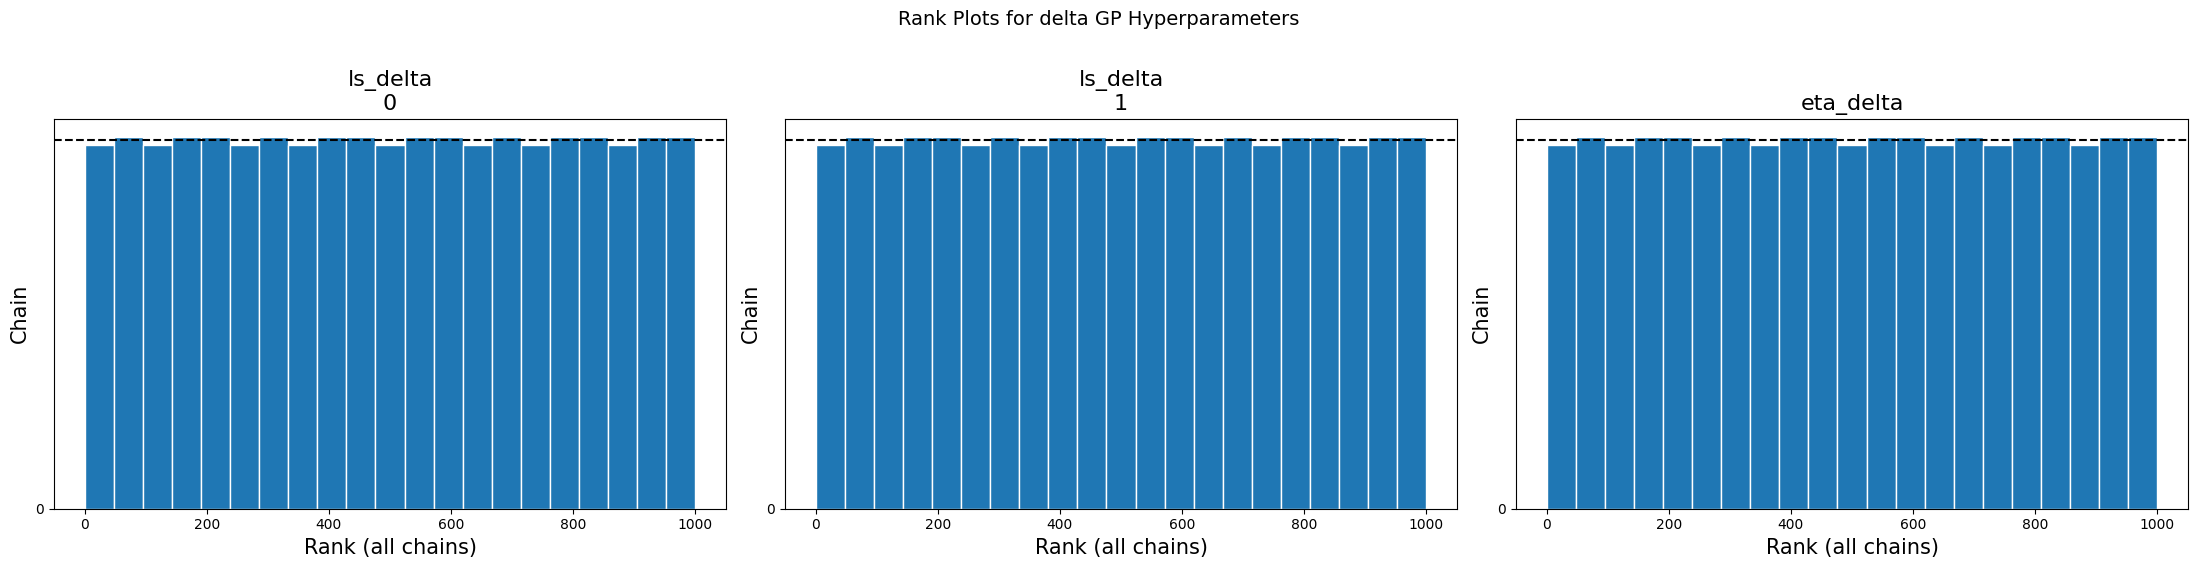

In [29]:
# delta GP의 length-scale과 amplitude 파라미터
az.plot_rank(trace, var_names=["ls_delta", "eta_delta"], ref_line=True)
plt.suptitle("Rank Plots for delta GP Hyperparameters", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


### 6-2. 칼리브레이션 파라미터 분석

theta_true는 모델 칼리브레이션의 핵심입니다. 물리적 단위로 변환된 값의 사후 분포를 상세히 분석합니다.


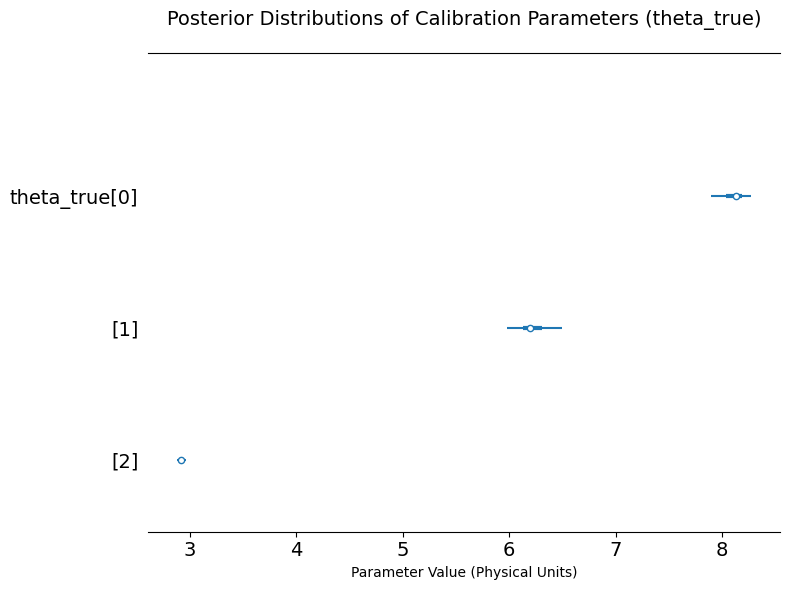

In [31]:
# 칼리브레이션 파라미터 (theta_true)의 사후 분포 플롯
# 물리적 단위로 변환된 값 사용
# trace_는 이미 Cell 25에서 물리적 단위로 변환된 trace

# Forest plot: 각 파라미터의 사후 분포 요약 (평균, HDI)
az.plot_forest(trace_, var_names=["theta_true"], combined=True, 
               r_hat=False, figsize=(8, 6))
plt.xlabel("Parameter Value (Physical Units)")
plt.title("Posterior Distributions of Calibration Parameters (theta_true)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [32]:
# 칼리브레이션 파라미터의 상세 통계
# 94% HDI (Highest Density Interval): 94% 신뢰구간
theta_true_stats = az.summary(trace_, var_names=["theta_true"], kind="stats", hdi_prob=0.94)
print("=== Calibration Parameters (theta_true) Statistics (Physical Units) ===")
print(theta_true_stats)
print("\n파라미터 의미:")
print("- theta_true[0]: Equipment Density (기기밀도)")
print("- theta_true[1]: Lighting Density (조명밀도)")
print("- theta_true[2]: COP (Coefficient of Performance)")


=== Calibration Parameters (theta_true) Statistics (Physical Units) ===
                mean     sd  hdi_3%  hdi_97%
theta_true[0]  8.109  0.109   7.893    8.274
theta_true[1]  6.222  0.144   5.974    6.500
theta_true[2]  2.916  0.025   2.877    2.960

파라미터 의미:
- theta_true[0]: Equipment Density (기기밀도)
- theta_true[1]: Lighting Density (조명밀도)
- theta_true[2]: COP (Coefficient of Performance)


#### 칼리브레이션 파라미터의 결합 분포 분석

파라미터 간의 상관관계와 불확실성 구조를 이해하는 것이 중요합니다.


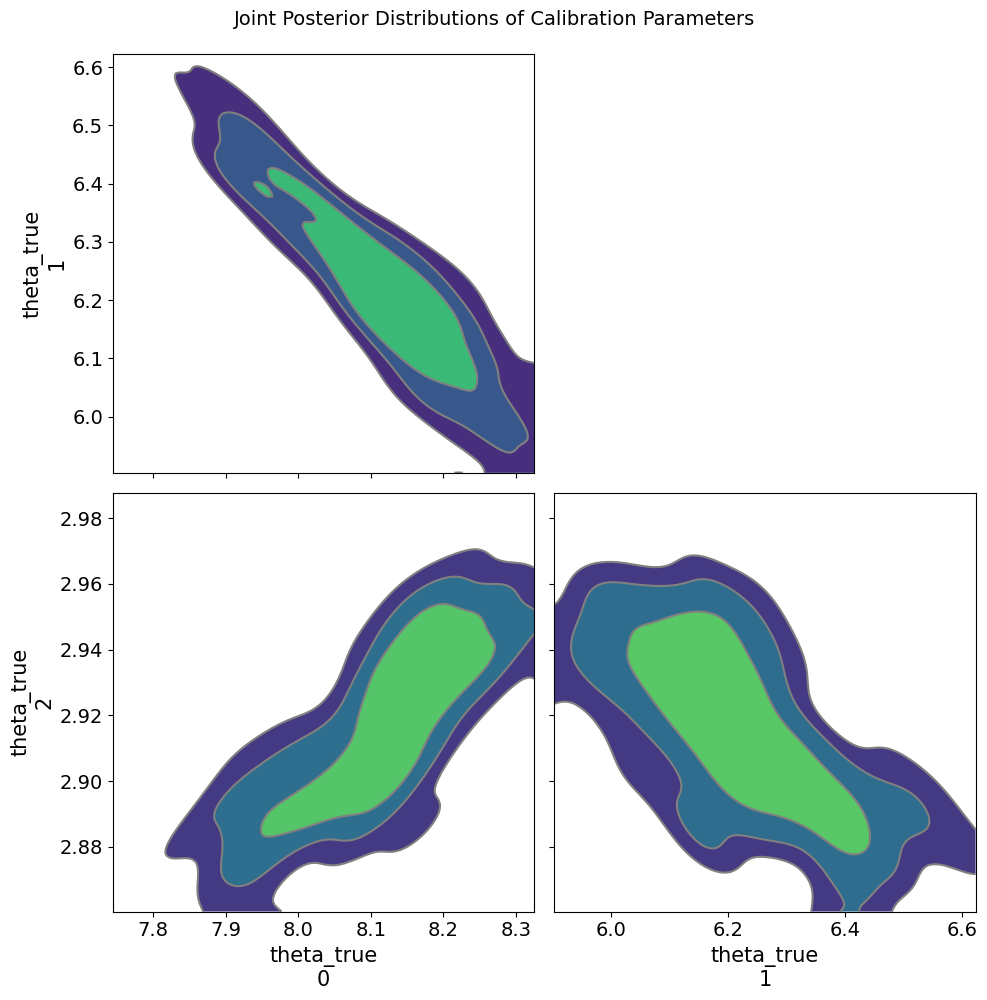

In [33]:
# Pair plot with KDE contours: 파라미터 간의 결합 분포와 상관관계 시각화
# 물리적 단위로 변환된 theta_true 값 사용
az.plot_pair(trace_, var_names=["theta_true"], kind="kde", 
             divergences=False, figsize=(10, 10))
plt.suptitle("Joint Posterior Distributions of Calibration Parameters", 
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()


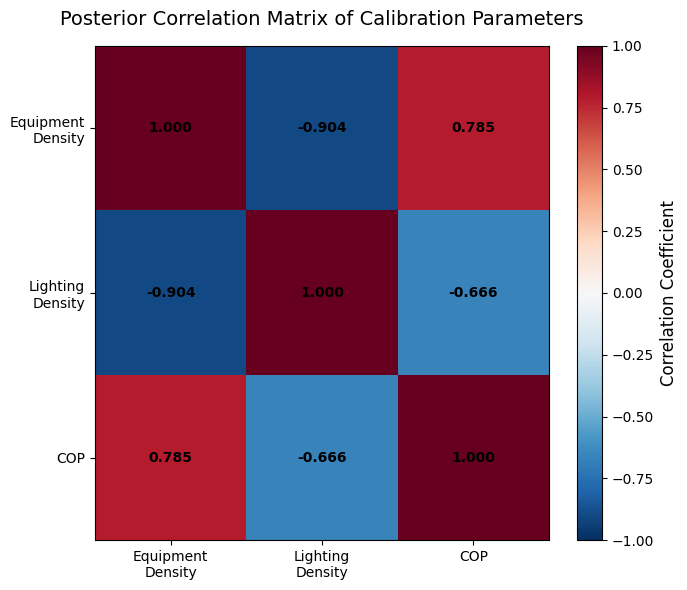

In [34]:
# 상관관계 행렬 계산 및 시각화
# theta_true 파라미터 간의 피어슨 상관계수 계산
import matplotlib.colors as mcolors

# 사후 샘플에서 상관계수 계산
theta_samples = az.extract(trace_, var_names=["theta_true"]).values.T  # (n_samples, 3)
corr_matrix = np.corrcoef(theta_samples.T)  # (3, 3)

# 상관관계 행렬 시각화
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")

# 축 레이블 설정
labels = ["Equipment\nDensity", "Lighting\nDensity", "COP"]
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# 상관계수 값을 텍스트로 표시
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, f"{corr_matrix[i, j]:.3f}",
                      ha="center", va="center", color="black", fontweight="bold")

# 컬러바 추가
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation Coefficient", fontsize=12)
ax.set_title("Posterior Correlation Matrix of Calibration Parameters", fontsize=14, pad=15)
plt.tight_layout()
plt.show()


### 6-3. Gaussian Process 하이퍼파라미터 분석

GP 하이퍼파라미터들은 함수의 특성을 결정합니다. eta GP와 delta GP의 하이퍼파라미터를 각각 분석합니다.


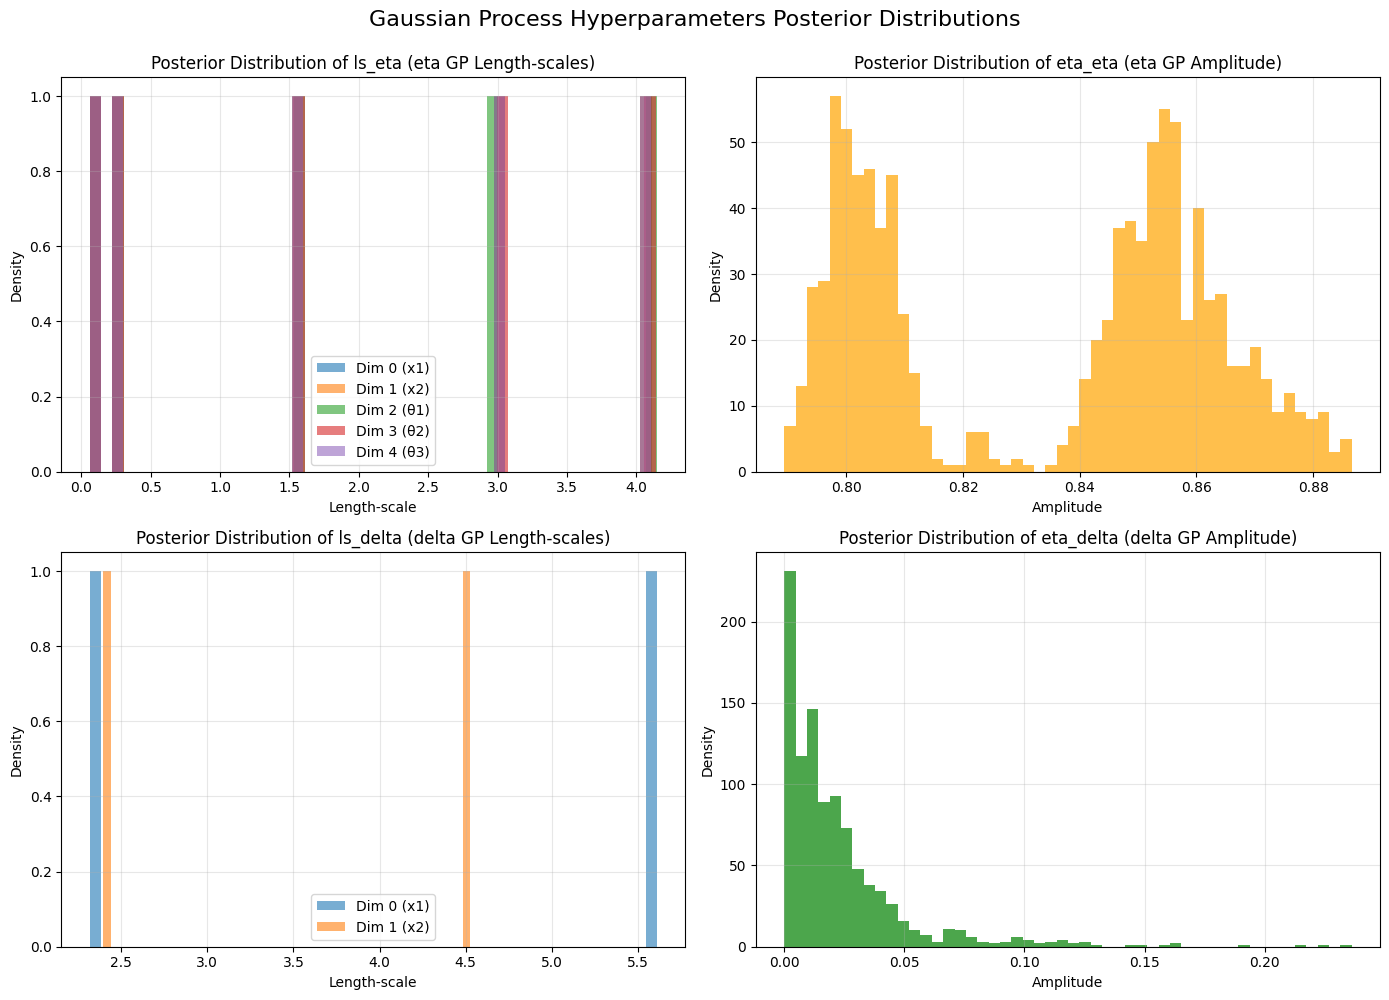

In [35]:
# eta GP 하이퍼파라미터의 사후 분포 플롯
# ls_eta: 각 입력 차원(x1, x2, theta1, theta2, theta3)에 대한 length-scale
# eta_eta: GP 함수의 amplitude
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# ls_eta (5차원) - 각 차원별로 플롯
ls_eta_samples = az.extract(trace, var_names=["ls_eta"]).values.T  # (5, n_samples)
for i in range(5):
    axes[0].hist(ls_eta_samples[i], bins=50, alpha=0.6, 
                label=f"Dim {i} ({['x1', 'x2', 'θ1', 'θ2', 'θ3'][i]})")
axes[0].set_xlabel("Length-scale")
axes[0].set_ylabel("Density")
axes[0].set_title("Posterior Distribution of ls_eta (eta GP Length-scales)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# eta_eta (amplitude)
eta_eta_samples = az.extract(trace, var_names=["eta_eta"]).values
axes[1].hist(eta_eta_samples, bins=50, alpha=0.7, color="orange")
axes[1].set_xlabel("Amplitude")
axes[1].set_ylabel("Density")
axes[1].set_title("Posterior Distribution of eta_eta (eta GP Amplitude)")
axes[1].grid(True, alpha=0.3)

# delta GP 하이퍼파라미터
# ls_delta (2차원)
ls_delta_samples = az.extract(trace, var_names=["ls_delta"]).values.T  # (2, n_samples)
for i in range(2):
    axes[2].hist(ls_delta_samples[i], bins=50, alpha=0.6, 
                label=f"Dim {i} ({['x1', 'x2'][i]})")
axes[2].set_xlabel("Length-scale")
axes[2].set_ylabel("Density")
axes[2].set_title("Posterior Distribution of ls_delta (delta GP Length-scales)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# eta_delta (amplitude)
eta_delta_samples = az.extract(trace, var_names=["eta_delta"]).values
axes[3].hist(eta_delta_samples, bins=50, alpha=0.7, color="green")
axes[3].set_xlabel("Amplitude")
axes[3].set_ylabel("Density")
axes[3].set_title("Posterior Distribution of eta_delta (delta GP Amplitude)")
axes[3].grid(True, alpha=0.3)

plt.suptitle("Gaussian Process Hyperparameters Posterior Distributions", 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


#### Length-scale 해석

Length-scale이 클수록 해당 차원에서 함수가 더 부드럽게 변합니다. 즉, 입력값이 크게 변해도 함수값의 변화가 작다는 의미입니다. 이를 통해 각 입력 변수의 중요성을 파악할 수 있습니다.


/tmp/ipykernel_1123341/1790749857.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(ls_eta_data, labels=labels, patch_artist=True,


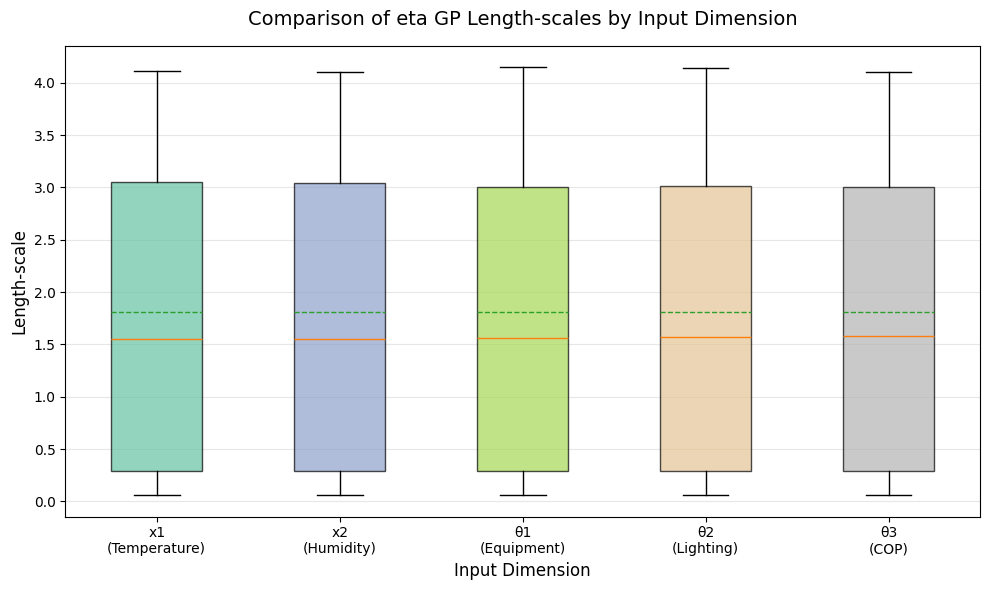

=== Average Length-scales for eta GP ===
x1
(Temperature): 1.8123
x2
(Humidity): 1.8117
θ1
(Equipment): 1.8122
θ2
(Lighting): 1.8140
θ3
(COP): 1.8069


In [36]:
# eta GP의 length-scale 비교 (박스플롯)
# 각 차원의 length-scale을 비교하여 상대적 중요도 파악
fig, ax = plt.subplots(figsize=(10, 6))

# ls_eta 데이터 준비 (5차원)
ls_eta_data = [ls_eta_samples[i] for i in range(5)]
labels = ["x1\n(Temperature)", "x2\n(Humidity)", "θ1\n(Equipment)", 
         "θ2\n(Lighting)", "θ3\n(COP)"]

bp = ax.boxplot(ls_eta_data, labels=labels, patch_artist=True, 
                showmeans=True, meanline=True)

# 박스플롯 스타일링
colors = plt.cm.Set2(np.linspace(0, 1, 5))
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel("Length-scale", fontsize=12)
ax.set_xlabel("Input Dimension", fontsize=12)
ax.set_title("Comparison of eta GP Length-scales by Input Dimension", fontsize=14, pad=15)
ax.grid(True, alpha=0.3, axis="y")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 평균 length-scale 출력
ls_eta_mean = ls_eta_samples.mean(axis=1)
print("=== Average Length-scales for eta GP ===")
for i, (label, mean_ls) in enumerate(zip(labels, ls_eta_mean)):
    print(f"{label}: {mean_ls:.4f}")


### 6-4. 노이즈 파라미터 분석

시뮬레이션 노이즈(sigma_c)와 관측 노이즈(sigma)를 분석하여 모델의 불확실성 구조를 이해합니다.


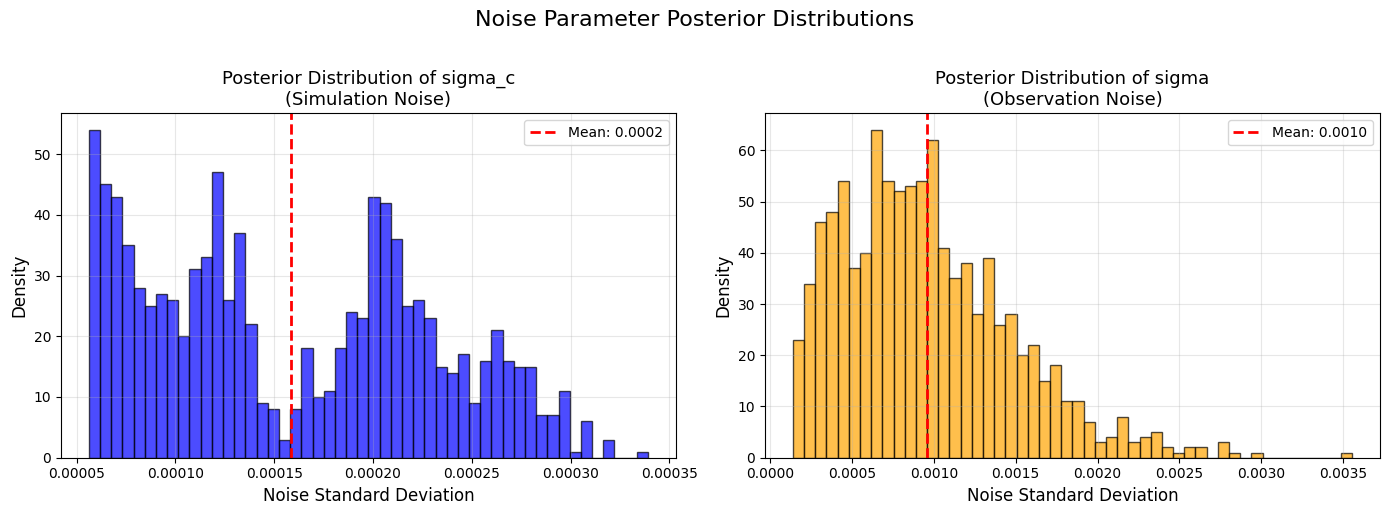

=== Noise Parameter Statistics ===
sigma_c (simulation): mean=0.000158, std=0.000071
sigma (observation): mean=0.000955, std=0.000521
Noise ratio (sigma/sigma_c): 6.03


In [37]:
# 노이즈 파라미터의 사후 분포 비교
sigma_c_samples = az.extract(trace, var_names=["sigma_c"]).values
sigma_samples = az.extract(trace, var_names=["sigma"]).values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# sigma_c (시뮬레이션 노이즈)
axes[0].hist(sigma_c_samples, bins=50, alpha=0.7, color="blue", edgecolor="black")
axes[0].axvline(sigma_c_samples.mean(), color="red", linestyle="--", linewidth=2, 
                label=f"Mean: {sigma_c_samples.mean():.4f}")
axes[0].set_xlabel("Noise Standard Deviation", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].set_title("Posterior Distribution of sigma_c\n(Simulation Noise)", fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# sigma (관측 노이즈)
axes[1].hist(sigma_samples, bins=50, alpha=0.7, color="orange", edgecolor="black")
axes[1].axvline(sigma_samples.mean(), color="red", linestyle="--", linewidth=2, 
                label=f"Mean: {sigma_samples.mean():.4f}")
axes[1].set_xlabel("Noise Standard Deviation", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].set_title("Posterior Distribution of sigma\n(Observation Noise)", fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle("Noise Parameter Posterior Distributions", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 노이즈 통계 출력
print("=== Noise Parameter Statistics ===")
print(f"sigma_c (simulation): mean={sigma_c_samples.mean():.6f}, "
      f"std={sigma_c_samples.std():.6f}")
print(f"sigma (observation): mean={sigma_samples.mean():.6f}, "
      f"std={sigma_samples.std():.6f}")
print(f"Noise ratio (sigma/sigma_c): {sigma_samples.mean()/sigma_c_samples.mean():.2f}")


### 6-5. 사후 예측 검사 (Posterior Predictive Checks)

사후 예측 검사를 통해 모델이 데이터를 잘 설명하는지 확인합니다. 시뮬레이션 데이터와 실제 관측 데이터 각각에 대해 검사를 수행합니다.


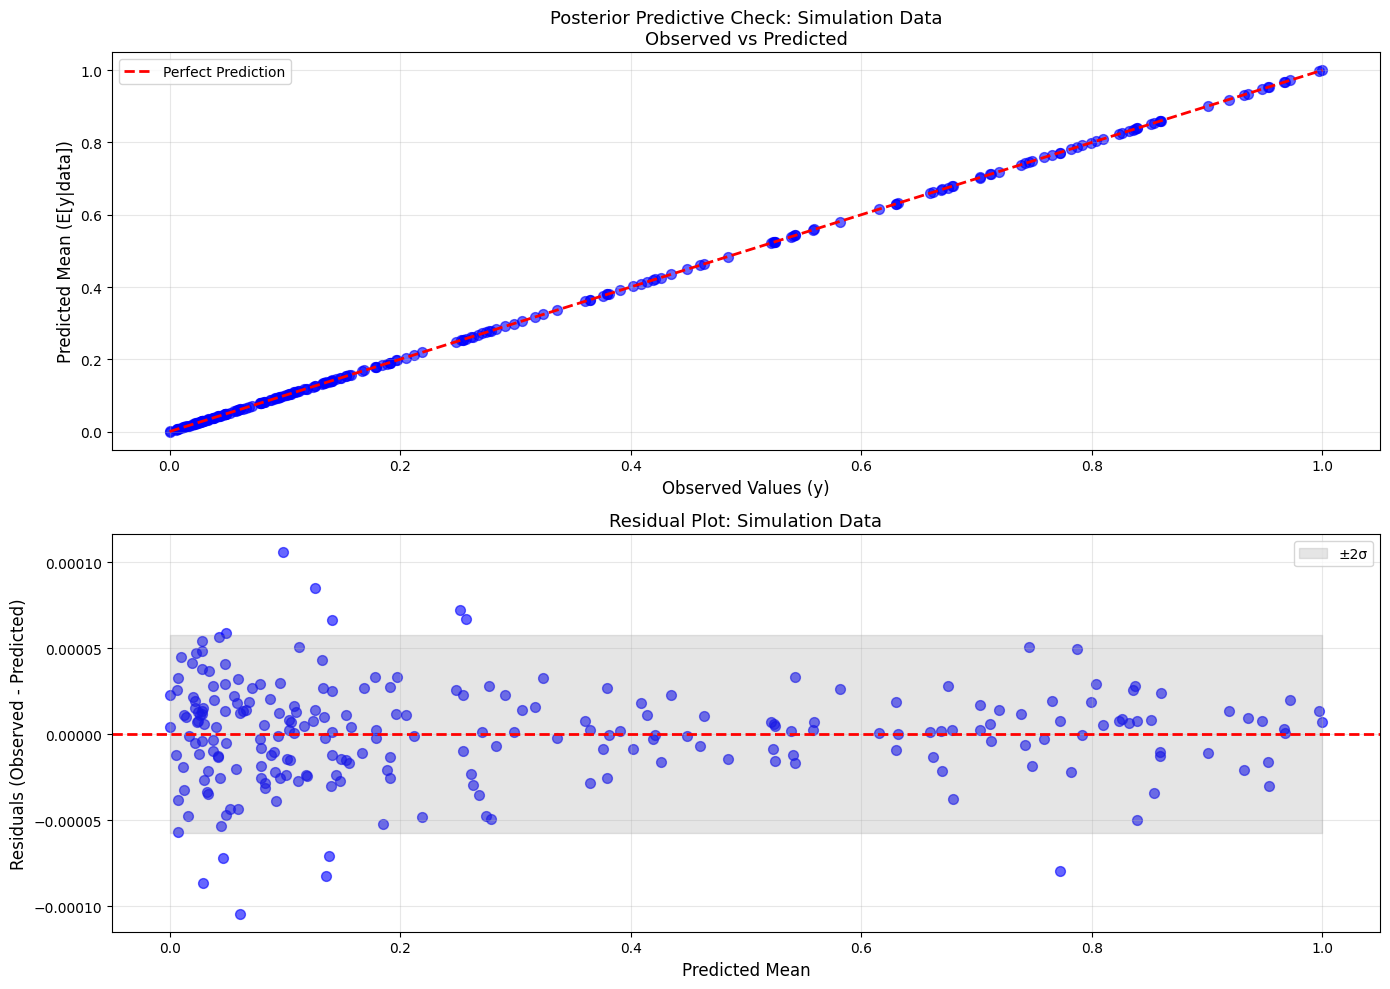

=== Simulation Data Posterior Predictive Check ===
RMSE: 0.000029
Mean Absolute Error: 0.000022
R-squared: 1.000000


In [38]:
# 시뮬레이션 데이터에 대한 사후 예측 검사
# y_obs: 시뮬레이션 데이터의 관측값
# samples.posterior_predictive.y_obs: 사후 예측 샘플

y_obs_samples = samples.posterior_predictive.y_obs.values  # (chain, draw, n_obs)

# 사후 예측 분포의 평균과 HDI 계산
y_pred_mean = y_obs_samples.mean(axis=(0, 1))
y_pred_lower = np.percentile(y_obs_samples, 2.5, axis=(0, 1))
y_pred_upper = np.percentile(y_obs_samples, 97.5, axis=(0, 1))

# 시뮬레이션 데이터 인덱스
sim_indices = np.arange(len(y))

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 상단: 예측값 vs 관측값 (산점도)
axes[0].scatter(y, y_pred_mean, alpha=0.6, s=50, color="blue")
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], "r--", linewidth=2, 
             label="Perfect Prediction")
axes[0].set_xlabel("Observed Values (y)", fontsize=12)
axes[0].set_ylabel("Predicted Mean (E[y|data])", fontsize=12)
axes[0].set_title("Posterior Predictive Check: Simulation Data\nObserved vs Predicted", fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 하단: 잔차 플롯
residuals = y - y_pred_mean
axes[1].scatter(y_pred_mean, residuals, alpha=0.6, s=50, color="blue")
axes[1].axhline(y=0, color="red", linestyle="--", linewidth=2)
axes[1].fill_between([y_pred_mean.min(), y_pred_mean.max()], 
                     2*np.std(residuals), -2*np.std(residuals), 
                     alpha=0.2, color="gray", label="±2σ")
axes[1].set_xlabel("Predicted Mean", fontsize=12)
axes[1].set_ylabel("Residuals (Observed - Predicted)", fontsize=12)
axes[1].set_title("Residual Plot: Simulation Data", fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 통계 요약
print("=== Simulation Data Posterior Predictive Check ===")
print(f"RMSE: {np.sqrt(np.mean(residuals**2)):.6f}")
print(f"Mean Absolute Error: {np.mean(np.abs(residuals)):.6f}")
print(f"R-squared: {1 - np.sum(residuals**2)/np.sum((y - y.mean())**2):.6f}")


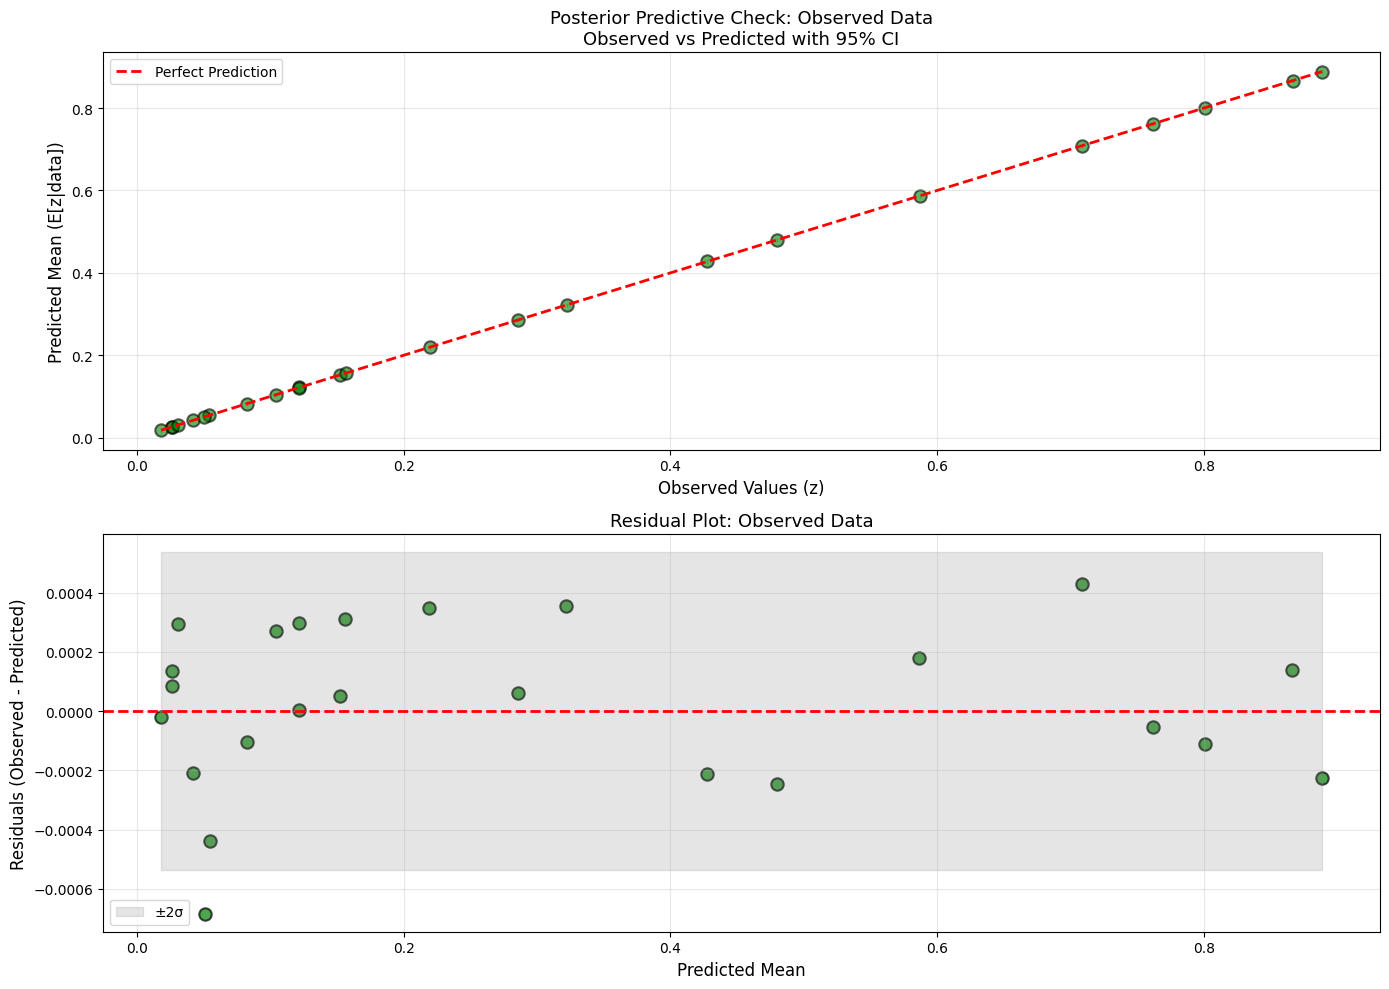

=== Observed Data Posterior Predictive Check ===
RMSE: 0.000270
Mean Absolute Error: 0.000219
R-squared: 0.999999

Coverage (95% CI): 100.0%


In [39]:
# 실제 관측 데이터에 대한 사후 예측 검사
# z_obs: 실제 관측 데이터
# samples.posterior_predictive.z_obs: 사후 예측 샘플

z_obs_samples = samples.posterior_predictive.z_obs.values  # (chain, draw, n_obs)

# 사후 예측 분포의 평균과 HDI 계산
z_pred_mean = z_obs_samples.mean(axis=(0, 1))
z_pred_lower = np.percentile(z_obs_samples, 2.5, axis=(0, 1))
z_pred_upper = np.percentile(z_obs_samples, 97.5, axis=(0, 1))

# 실제 관측 데이터 인덱스
obs_indices = np.arange(len(z))

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 상단: 예측값 vs 관측값 (산점도)
axes[0].scatter(z, z_pred_mean, alpha=0.6, s=80, color="green", 
                edgecolors="black", linewidths=1.5)
# 신뢰구간 표시
for i in range(len(z)):
    axes[0].plot([z[i], z[i]], [z_pred_lower[i], z_pred_upper[i]], 
                 "g-", alpha=0.3, linewidth=1)
axes[0].plot([z.min(), z.max()], [z.min(), z.max()], "r--", linewidth=2, 
             label="Perfect Prediction")
axes[0].set_xlabel("Observed Values (z)", fontsize=12)
axes[0].set_ylabel("Predicted Mean (E[z|data])", fontsize=12)
axes[0].set_title("Posterior Predictive Check: Observed Data\nObserved vs Predicted with 95% CI", fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 하단: 잔차 플롯
z_residuals = z - z_pred_mean
axes[1].scatter(z_pred_mean, z_residuals, alpha=0.7, s=80, color="green", 
                edgecolors="black", linewidths=1.5)
axes[1].axhline(y=0, color="red", linestyle="--", linewidth=2)
axes[1].fill_between([z_pred_mean.min(), z_pred_mean.max()], 
                     2*np.std(z_residuals), -2*np.std(z_residuals), 
                     alpha=0.2, color="gray", label="±2σ")
axes[1].set_xlabel("Predicted Mean", fontsize=12)
axes[1].set_ylabel("Residuals (Observed - Predicted)", fontsize=12)
axes[1].set_title("Residual Plot: Observed Data", fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 통계 요약
print("=== Observed Data Posterior Predictive Check ===")
print(f"RMSE: {np.sqrt(np.mean(z_residuals**2)):.6f}")
print(f"Mean Absolute Error: {np.mean(np.abs(z_residuals)):.6f}")
print(f"R-squared: {1 - np.sum(z_residuals**2)/np.sum((z - z.mean())**2):.6f}")
print(f"\nCoverage (95% CI): {(np.sum((z >= z_pred_lower) & (z <= z_pred_upper)) / len(z) * 100):.1f}%")


#### 사후 예측 분포의 히스토그램 비교

관측 데이터와 사후 예측 샘플의 분포를 비교하여 모델이 데이터 분포를 잘 포착하는지 확인합니다.


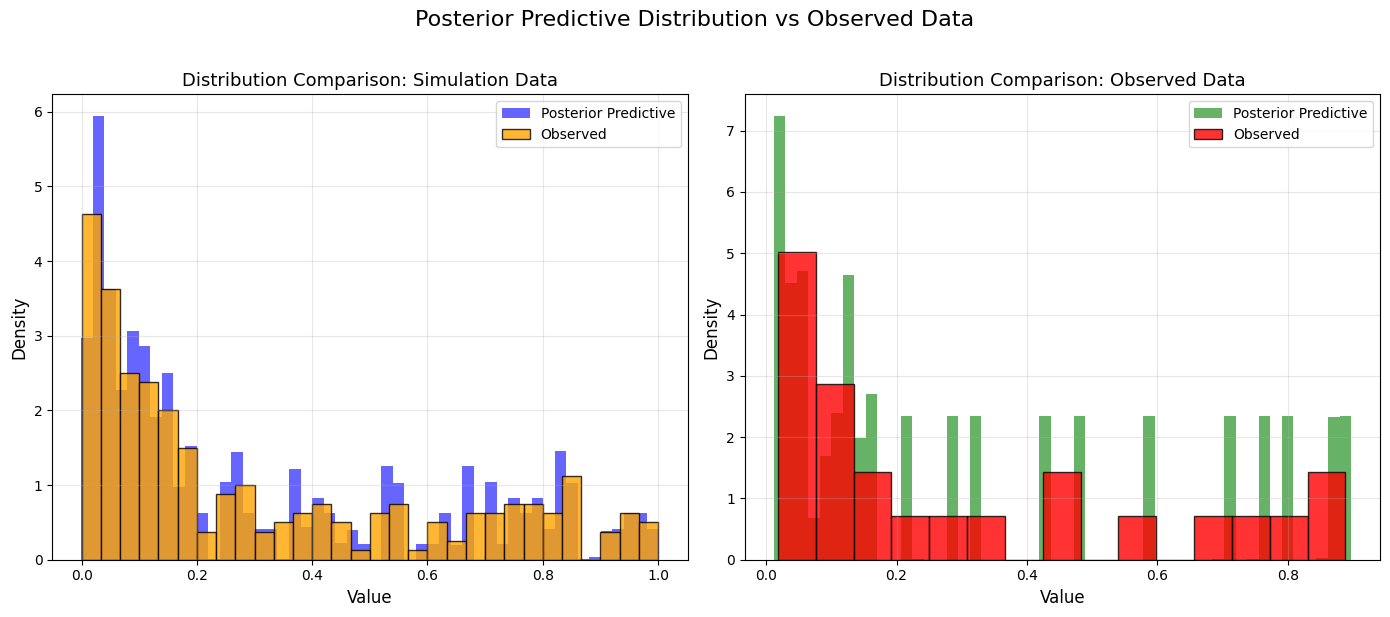

In [40]:
# 사후 예측 분포와 관측 데이터 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 시뮬레이션 데이터
# 사후 예측 샘플을 평탄화 (flatten)
y_pred_flat = y_obs_samples.flatten()
axes[0].hist(y_pred_flat, bins=50, alpha=0.6, label="Posterior Predictive", 
             color="blue", density=True)
axes[0].hist(y, bins=30, alpha=0.8, label="Observed", 
             color="orange", density=True, edgecolor="black")
axes[0].set_xlabel("Value", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].set_title("Distribution Comparison: Simulation Data", fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 실제 관측 데이터
z_pred_flat = z_obs_samples.flatten()
axes[1].hist(z_pred_flat, bins=50, alpha=0.6, label="Posterior Predictive", 
             color="green", density=True)
axes[1].hist(z, bins=15, alpha=0.8, label="Observed", 
             color="red", density=True, edgecolor="black")
axes[1].set_xlabel("Value", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].set_title("Distribution Comparison: Observed Data", fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle("Posterior Predictive Distribution vs Observed Data", 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### 6-6. 모델 불일치 함수 (Model Discrepancy) 분석

KOH 프레임워크의 핵심인 모델 불일치 함수 $\delta(\bold{x})$를 분석합니다. 이 함수는 시뮬레이터와 실제 물리 프로세스 사이의 체계적 차이를 나타냅니다.


In [41]:
# 모델 불일치 함수 delta의 사후 샘플 추출
# f_p_delta가 Deterministic 변수이므로 trace에서 직접 추출 가능
# 하지만 실제로는 GP prior에서 샘플링되므로, 사후 예측을 통해 추정

# 대안: 사후 분포에서 샘플링된 theta_true를 사용하여 GP 예측 수행
# 여기서는 간단히 f_p_eta와 f_p의 차이로 추정
# (실제로는 더 정교한 방법이 필요하지만, 개념적 이해를 위해)

with koh_model:
    # 사후 샘플에서 theta_true 추출
    theta_true_post = az.extract(trace, var_names=["theta_true"]).values
    
    # 사후 분포의 평균값 사용
    theta_true_mean = theta_true_post.mean(axis=0)
    
    # 각 관측점에서 delta 값 추정 (간단한 버전)
    # 실제로는 GP conditional 예측을 사용해야 함
    # 여기서는 개념적 시각화만 수행
    pass

print("Note: 정확한 delta 분석을 위해서는 GP conditional 예측이 필요합니다.")
print("현재는 하이퍼파라미터 분석을 통해 delta GP의 특성을 파악할 수 있습니다.")


Note: 정확한 delta 분석을 위해서는 GP conditional 예측이 필요합니다.
현재는 하이퍼파라미터 분석을 통해 delta GP의 특성을 파악할 수 있습니다.


#### eta vs delta GP 비교

eta GP (시뮬레이션 함수)와 delta GP (모델 불일치)의 하이퍼파라미터를 비교하여 상대적 중요도를 파악합니다.


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (1000,).

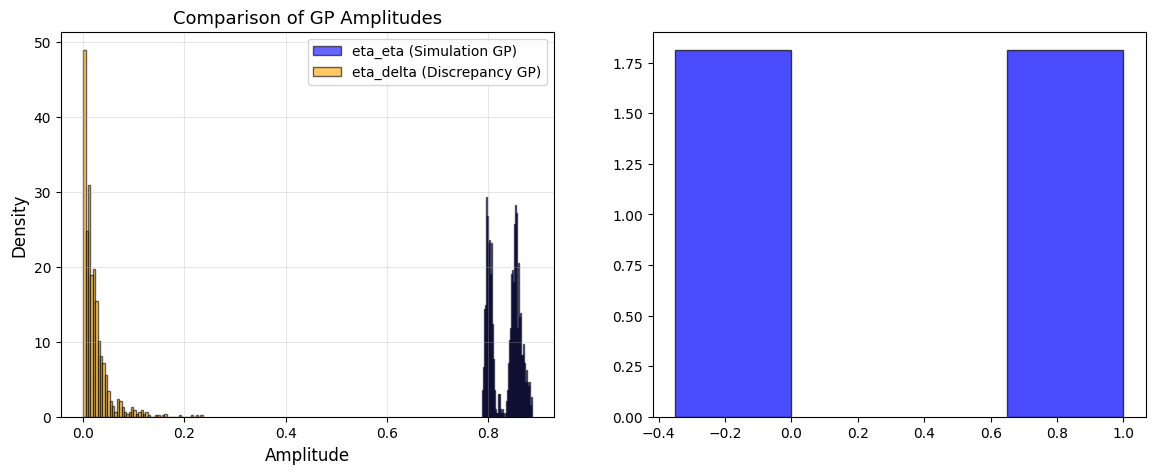

In [51]:
# eta GP와 delta GP의 amplitude 및 length-scale 비교
# amplitude가 클수록 함수의 변동성이 크고, length-scale이 클수록 함수가 부드럽게 변함

# 1. GP amplitude 파라미터 추출
# eta_eta: eta GP의 amplitude (스칼라)
# eta_delta: delta GP의 amplitude (스칼라)
eta_eta_samples = az.extract(trace, var_names=["eta_eta"]).values
eta_delta_samples = az.extract(trace, var_names=["eta_delta"]).values

# 2. GP length-scale 파라미터 추출
# ls_eta: eta GP의 length-scale (5차원: x1, x2, theta1, theta2, theta3)
# ls_delta: delta GP의 length-scale (2차원: x1, x2)
# az.extract()는 xarray를 반환하며, .values는 numpy array를 반환
# shape: (n_samples, n_dims) 형태이므로 transpose하여 (n_dims, n_samples)로 변환
ls_eta_extracted = az.extract(trace, var_names=["ls_eta"]).values  # (n_samples, 5)
ls_delta_extracted = az.extract(trace, var_names=["ls_delta"]).values  # (n_samples, 2)

# transpose하여 (n_dims, n_samples) 형태로 변환
ls_eta_samples = ls_eta_extracted.T  # (5, n_samples): [x1, x2, theta1, theta2, theta3]
ls_delta_samples = ls_delta_extracted.T  # (2, n_samples): [x1, x2]

# 3. x1, x2에 대한 평균 length-scale 계산
# eta GP의 첫 두 차원(x1, x2)과 delta GP의 전체 차원(x1, x2) 비교
ls_eta_x1x2 = ls_eta_samples[:2, :]  # (2, n_samples): x1, x2에 대한 eta GP length-scale
ls_delta_x1x2 = ls_delta_samples  # (2, n_samples): x1, x2에 대한 delta GP length-scale

# 각 차원별로 평균 계산 (axis=1: 각 차원에 대해 모든 샘플의 평균)
ls_eta_x_mean = ls_eta_x1x2.mean(axis=1)  # (2,): [x1 평균, x2 평균]
ls_delta_x_mean = ls_delta_x1x2.mean(axis=1)  # (2,): [x1 평균, x2 평균]

# 4. 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) Amplitude 비교 히스토그램
axes[0].hist(eta_eta_samples, bins=50, alpha=0.6, label="eta_eta (Simulation GP)", 
             color="blue", density=True, edgecolor="black")
axes[0].hist(eta_delta_samples, bins=50, alpha=0.6, label="eta_delta (Discrepancy GP)", 
             color="orange", density=True, edgecolor="black")
axes[0].set_xlabel("Amplitude", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].set_title("Comparison of GP Amplitudes", fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# (2) Length-scale 비교 바 차트
x_pos = np.arange(2)  # x1과 x2에 대한 위치
width = 0.35  # 바 너비

# eta GP와 delta GP의 length-scale을 나란히 표시
bars1 = axes[1].bar(x_pos - width/2, ls_eta_x_mean, width, label="eta GP", 
                    alpha=0.7, color="blue", edgecolor="black")
bars2 = axes[1].bar(x_pos + width/2, ls_delta_x_mean, width, label="delta GP", 
                    alpha=0.7, color="orange", edgecolor="black")

axes[1].set_xlabel("Input Dimension", fontsize=12)
axes[1].set_ylabel("Mean Length-scale", fontsize=12)
axes[1].set_title("Length-scale Comparison: eta vs delta GP\n(for x1 and x2)", fontsize=13)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(["x1\n(Temperature)", "x2\n(Humidity)"])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis="y")

plt.suptitle("Comparison of eta GP and delta GP Characteristics", 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 5. 수치 요약 출력
print("=== GP Comparison Summary ===")
print(f"Amplitude:")
print(f"  eta_eta (simulation) mean: {eta_eta_samples.mean():.4f} ± {eta_eta_samples.std():.4f}")
print(f"  eta_delta (discrepancy) mean: {eta_delta_samples.mean():.4f} ± {eta_delta_samples.std():.4f}")
print(f"  Ratio (delta/eta): {eta_delta_samples.mean()/eta_eta_samples.mean():.4f}")
print(f"\nLength-scales for x1, x2:")
print(f"  eta GP - x1: {ls_eta_x_mean[0]:.4f}, x2: {ls_eta_x_mean[1]:.4f}")
print(f"  delta GP - x1: {ls_delta_x_mean[0]:.4f}, x2: {ls_delta_x_mean[1]:.4f}")


### 6-7. Energy Plot 및 Autocorrelation 분석

MCMC 샘플러의 품질을 평가하기 위한 추가 진단입니다.


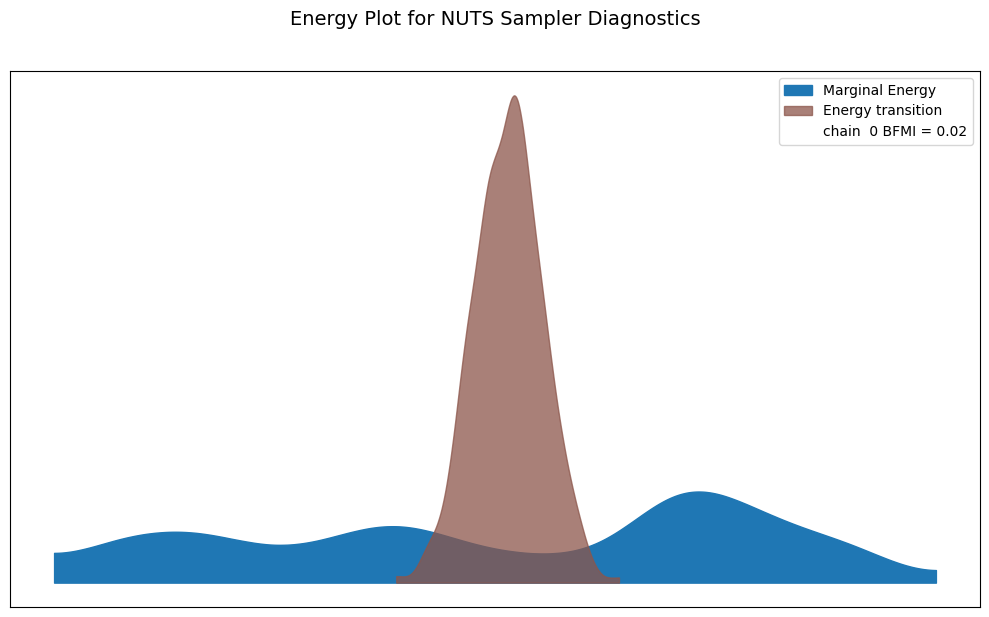

In [44]:
# Energy plot: HMC/NUTS 샘플러의 특성 진단
# 이진 분포 (marginal energy vs energy transition)가 잘 섞여야 함
az.plot_energy(trace, figsize=(10, 6))
plt.suptitle("Energy Plot for NUTS Sampler Diagnostics", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


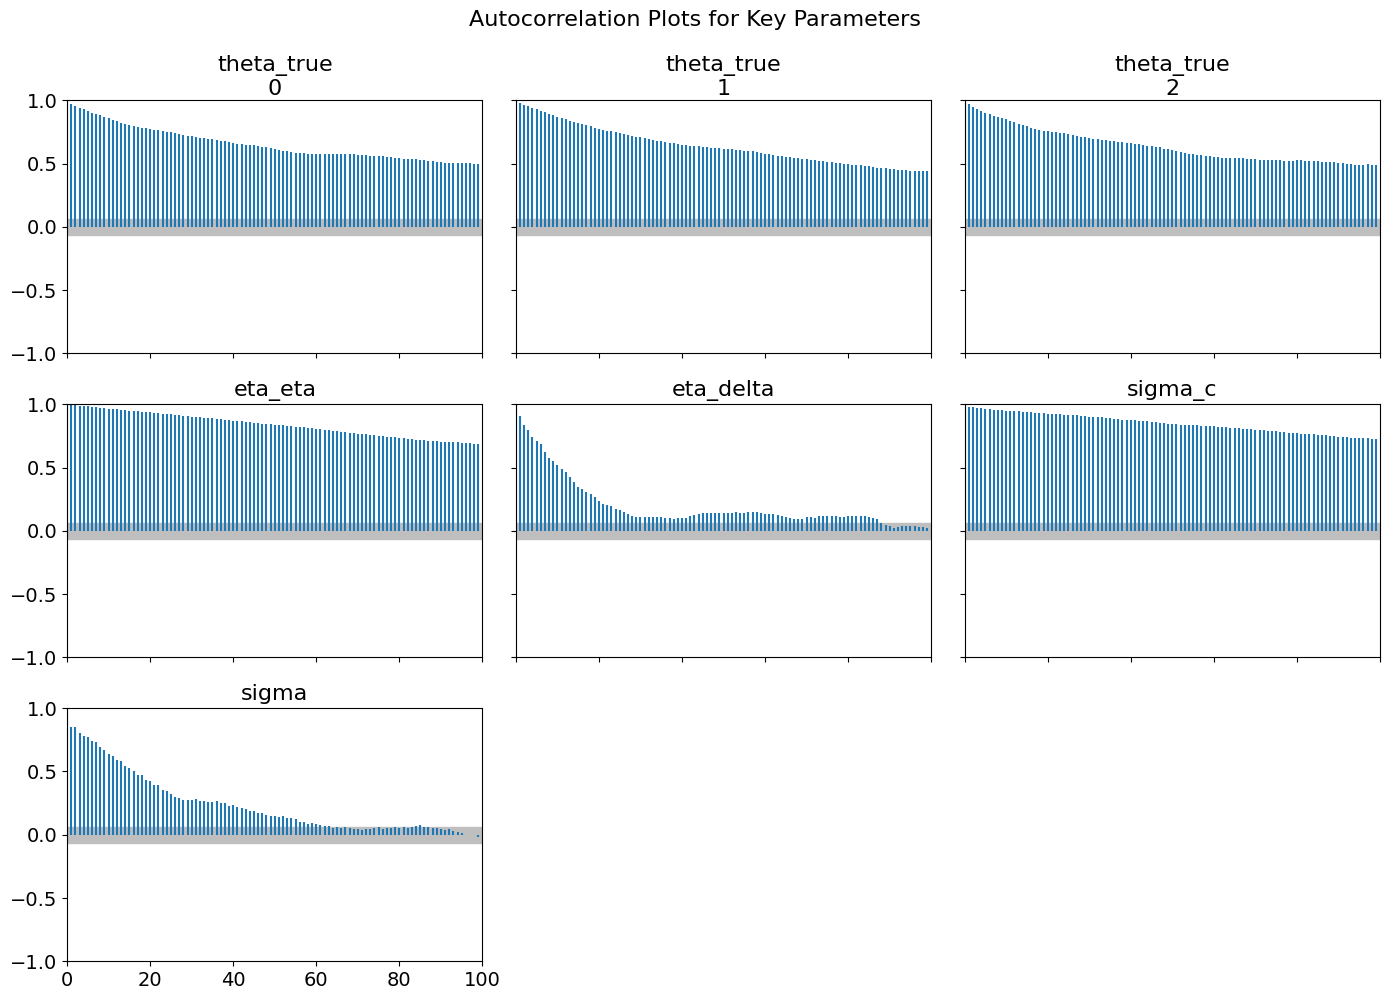

In [45]:
# Autocorrelation plot: 샘플 간의 상관관계 확인
# 낮은 autocorrelation이 이상적 (빠른 수렴, 높은 ESS)
az.plot_autocorr(trace, var_names=["theta_true", "eta_eta", "eta_delta", "sigma_c", "sigma"], 
                 max_lag=100, combined=True, figsize=(14, 10))
plt.suptitle("Autocorrelation Plots for Key Parameters", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


### 6-8. 파라미터 불확실성 정량화

각 파라미터의 불확실성을 정량화하여 실용적인 해석을 제공합니다.


In [46]:
# 칼리브레이션 파라미터의 불확실성 정량화
# 물리적 단위로 변환된 theta_true 사용

theta_true_samples = az.extract(trace_, var_names=["theta_true"]).values.T  # (3, n_samples)

# 각 파라미터에 대한 통계
param_names = ["Equipment Density", "Lighting Density", "COP"]
confidence_levels = [0.5, 0.68, 0.90, 0.95]

print("=== Calibration Parameter Uncertainty Quantification ===\n")

for i, name in enumerate(param_names):
    samples = theta_true_samples[i]
    mean_val = samples.mean()
    std_val = samples.std()
    
    print(f"{name} (theta_true[{i}]):")
    print(f"  Mean: {mean_val:.4f}")
    print(f"  Std: {std_val:.4f}")
    print(f"  Coefficient of Variation (CV): {std_val/mean_val*100:.2f}%")
    
    # 여러 신뢰구간 계산
    hdis = []
    for cl in confidence_levels:
        lower = np.percentile(samples, (1-cl)/2 * 100)
        upper = np.percentile(samples, (1+cl)/2 * 100)
        hdis.append((cl, lower, upper))
        print(f"  {int(cl*100)}% HDI: [{lower:.4f}, {upper:.4f}]")
    print()


=== Calibration Parameter Uncertainty Quantification ===

Equipment Density (theta_true[0]):
  Mean: 5.7547
  Std: 2.1419
  Coefficient of Variation (CV): 37.22%
  50% HDI: [4.6020, 7.1819]
  68% HDI: [3.9894, 7.4980]
  90% HDI: [3.2407, 7.8844]
  95% HDI: [3.0705, 7.9723]

Lighting Density (theta_true[1]):
  Mean: 5.7579
  Std: 2.1451
  Coefficient of Variation (CV): 37.25%
  50% HDI: [4.6024, 7.1866]
  68% HDI: [3.9897, 7.5042]
  90% HDI: [3.2409, 7.8924]
  95% HDI: [3.0707, 7.9807]

COP (theta_true[2]):
  Mean: 5.7496
  Std: 2.1512
  Coefficient of Variation (CV): 37.41%
  50% HDI: [4.5749, 7.1738]
  68% HDI: [3.9723, 7.5068]
  90% HDI: [3.2358, 7.9139]
  95% HDI: [3.0684, 8.0064]



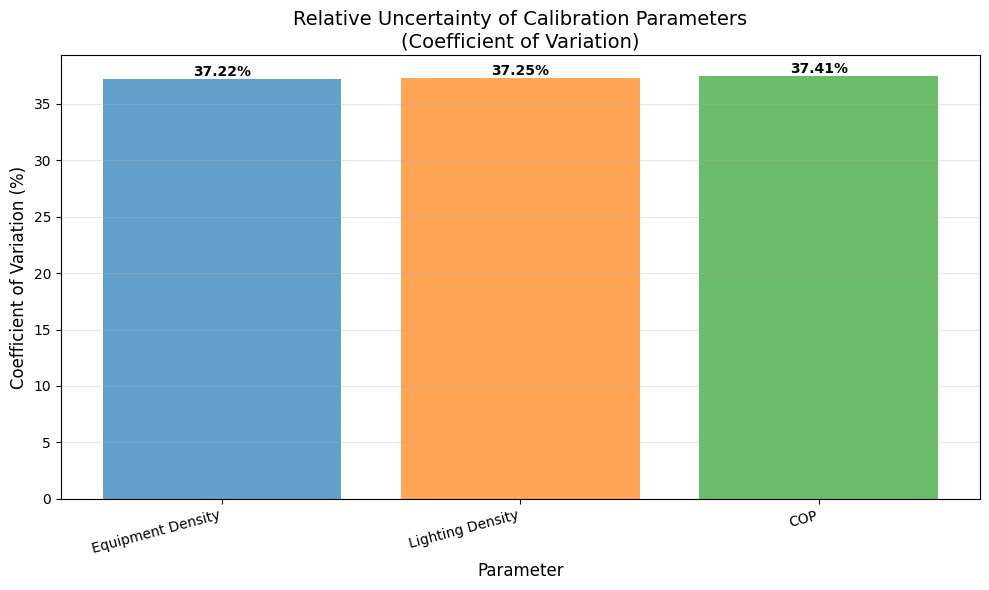

In [47]:
# 불확실성 비교 시각화 (Coefficient of Variation)
# CV가 클수록 상대적 불확실성이 큼

cvs = [theta_true_samples[i].std() / theta_true_samples[i].mean() * 100 
       for i in range(3)]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(param_names, cvs, alpha=0.7, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
ax.set_ylabel("Coefficient of Variation (%)", fontsize=12)
ax.set_xlabel("Parameter", fontsize=12)
ax.set_title("Relative Uncertainty of Calibration Parameters\n(Coefficient of Variation)", fontsize=14)
ax.grid(True, alpha=0.3, axis="y")

# 값 표시
for bar, cv in zip(bars, cvs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{cv:.2f}%',
            ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()


### 6-9. 모델 예측 정확도 시각화

공간적으로 분포된 관측 데이터에 대한 모델 예측을 시각화하여 지역별 적합도를 확인합니다.


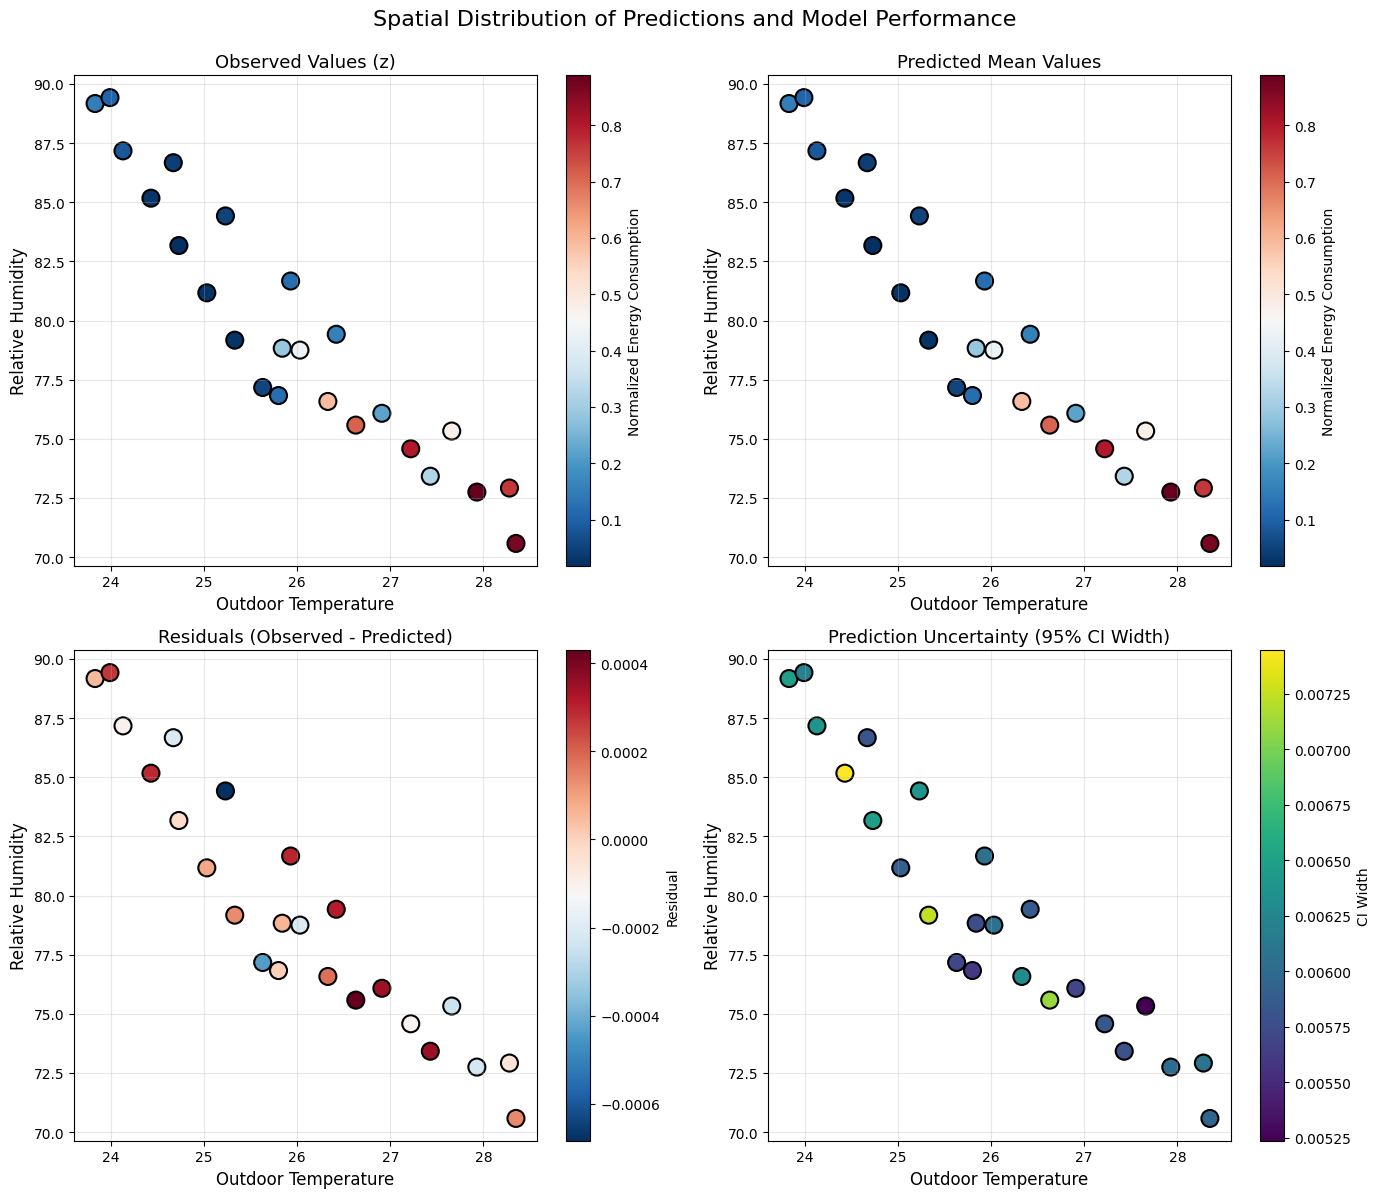

In [52]:
# 실제 관측 데이터의 공간 분포와 예측값 비교
# x_p (정규화된 좌표)를 원래 좌표로 역변환
x_p_original = x_p * (x_c_max - x_c_min) + x_c_min

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# (1) 관측값 분포
ax1 = axes[0, 0]
scatter1 = ax1.scatter(x_p_original[:, 0], x_p_original[:, 1], 
                       c=z, s=150, cmap="RdBu_r", 
                       edgecolors="black", linewidths=1.5)
ax1.set_xlabel("Outdoor Temperature", fontsize=12)
ax1.set_ylabel("Relative Humidity", fontsize=12)
ax1.set_title("Observed Values (z)", fontsize=13)
plt.colorbar(scatter1, ax=ax1, label="Normalized Energy Consumption")
ax1.grid(True, alpha=0.3)

# (2) 예측값 분포
ax2 = axes[0, 1]
scatter2 = ax2.scatter(x_p_original[:, 0], x_p_original[:, 1], 
                       c=z_pred_mean, s=150, cmap="RdBu_r", 
                       edgecolors="black", linewidths=1.5)
ax2.set_xlabel("Outdoor Temperature", fontsize=12)
ax2.set_ylabel("Relative Humidity", fontsize=12)
ax2.set_title("Predicted Mean Values", fontsize=13)
plt.colorbar(scatter2, ax=ax2, label="Normalized Energy Consumption")
ax2.grid(True, alpha=0.3)

# (3) 잔차 분포
ax3 = axes[1, 0]
scatter3 = ax3.scatter(x_p_original[:, 0], x_p_original[:, 1], 
                       c=z_residuals, s=150, cmap="RdBu_r", 
                       edgecolors="black", linewidths=1.5)
ax3.set_xlabel("Outdoor Temperature", fontsize=12)
ax3.set_ylabel("Relative Humidity", fontsize=12)
ax3.set_title("Residuals (Observed - Predicted)", fontsize=13)
plt.colorbar(scatter3, ax=ax3, label="Residual")
ax3.grid(True, alpha=0.3)

# (4) 예측 불확실성 (95% CI 폭)
ci_width = z_pred_upper - z_pred_lower
scatter4 = axes[1, 1].scatter(x_p_original[:, 0], x_p_original[:, 1], 
                              c=ci_width, s=150, cmap="viridis", 
                              edgecolors="black", linewidths=1.5)
axes[1, 1].set_xlabel("Outdoor Temperature", fontsize=12)
axes[1, 1].set_ylabel("Relative Humidity", fontsize=12)
axes[1, 1].set_title("Prediction Uncertainty (95% CI Width)", fontsize=13)
plt.colorbar(scatter4, ax=axes[1, 1], label="CI Width")
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle("Spatial Distribution of Predictions and Model Performance", 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


### 6-10. 종합 요약 및 결론

주요 칼리브레이션 결과를 요약하여 실용적인 인사이트를 제공합니다.


In [50]:
# 종합 요약 테이블 생성
import pandas as pd

summary_data = {
    "Parameter": ["Equipment Density", "Lighting Density", "COP"],
    "Symbol": ["θ₁", "θ₂", "θ₃"],
    "Mean": [theta_true_samples[i].mean() for i in range(3)],
    "Std": [theta_true_samples[i].std() for i in range(3)],
    "CV (%)": [theta_true_samples[i].std() / theta_true_samples[i].mean() * 100 for i in range(3)],
    "95% HDI Lower": [np.percentile(theta_true_samples[i], 2.5) for i in range(3)],
    "95% HDI Upper": [np.percentile(theta_true_samples[i], 97.5) for i in range(3)],
}

summary_df = pd.DataFrame(summary_data)
print("="*80)
print("FINAL CALIBRATION RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("\n")

# 모델 성능 요약
print("="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(f"Simulation Data:")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.6f}")
print(f"  R²: {1 - np.sum(residuals**2)/np.sum((y - y.mean())**2):.6f}")
print(f"\nObserved Data:")
print(f"  RMSE: {np.sqrt(np.mean(z_residuals**2)):.6f}")
print(f"  R²: {1 - np.sum(z_residuals**2)/np.sum((z - z.mean())**2):.6f}")
print(f"  95% CI Coverage: {(np.sum((z >= z_pred_lower) & (z <= z_pred_upper)) / len(z) * 100):.1f}%")
print("\n")

# GP 특성 요약
print("="*80)
print("GAUSSIAN PROCESS CHARACTERISTICS")
print("="*80)
print(f"eta GP (Simulation):")
print(f"  Amplitude (eta_eta): {eta_eta_samples.mean():.4f} ± {eta_eta_samples.std():.4f}")
print(f"  Avg Length-scale (x1, x2): {ls_eta_x_mean.mean():.4f}")
print(f"\ndelta GP (Model Discrepancy):")
print(f"  Amplitude (eta_delta): {eta_delta_samples.mean():.4f} ± {eta_delta_samples.std():.4f}")
print(f"  Avg Length-scale (x1, x2): {ls_delta_mean.mean():.4f}")
print(f"\nRelative Importance (delta/eta amplitude): {eta_delta_samples.mean()/eta_eta_samples.mean():.2f}")
print("="*80)


FINAL CALIBRATION RESULTS SUMMARY
        Parameter Symbol     Mean      Std    CV (%)  95% HDI Lower  95% HDI Upper
Equipment Density     θ₁ 5.754678 2.141924 37.220579       3.070492       7.972251
 Lighting Density     θ₂ 5.757913 2.145087 37.254587       3.070675       7.980676
              COP     θ₃ 5.749552 2.151182 37.414776       3.068394       8.006368


MODEL PERFORMANCE SUMMARY
Simulation Data:
  RMSE: 0.000029
  R²: 1.000000

Observed Data:
  RMSE: 0.000270
  R²: 0.999999
  95% CI Coverage: 100.0%


GAUSSIAN PROCESS CHARACTERISTICS
eta GP (Simulation):
  Amplitude (eta_eta): 0.8341 ± 0.0283
  Avg Length-scale (x1, x2): 1.8120

delta GP (Model Discrepancy):
  Amplitude (eta_delta): 0.0227 ± 0.0275
  Avg Length-scale (x1, x2): 4.1423

Relative Importance (delta/eta amplitude): 0.03
